## 导入必要的库

In [1]:
import struct
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.backends.backend_pdf import PdfPages
import time
import torch
from torch import nn 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
import tqdm as tqdm
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
from numpy import matlib

## 将Cifar-10数据文件导入并解析

In [2]:
path='cifar-10/data_batch_1'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data_dict=unpickle(path)
# 提取数据和标签
train_images = data_dict[b'data']  # 提取图像数据
train_labels = data_dict[b'labels']  # 提取标签数据
import numpy as np
train_images = np.array(train_images)
train_labels = np.array(train_labels)  # 转换为 NumPy 数组
train_images = train_images.reshape(10000, 3, 32, 32)
random_numbers = random.sample(range(10000), 500)
train_images=train_images[random_numbers,:,:,:]
train_labels=train_labels[random_numbers]
np.save('train_images_cifar.npy', train_images)
np.save('train_labels_cifar.npy', train_labels)
np.save('random_numbers_cifar.npy', random_numbers)

## 将MNIST数据文件导入并解析

In [19]:

# 训练集标签和图像文件路径
train_labels_file = './MNIST/train-labels.idx1-ubyte'
train_images_file = './MNIST/train-images.idx3-ubyte'

# 测试集标签和图像文件路径
test_labels_file = './MNIST/t10k-labels.idx1-ubyte'
test_images_file = './MNIST/t10k-images.idx3-ubyte'
def read_idx_file(file_path):
    with open(file_path, 'rb') as f:
        # 读取头部信息
        magic_number = struct.unpack('>I', f.read(4))[0]
        num_items = struct.unpack('>I', f.read(4))[0]

        # 读取标签数据
        if magic_number == 2049:  # 判断是否为标签文件
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels
        # 读取图像数据
        elif magic_number == 2051:  # 判断是否为图像文件
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            pixels = np.frombuffer(f.read(), dtype=np.uint8)
            images = pixels.reshape(num_items, num_rows, num_cols)
            return images
        else:
            raise ValueError("未知的文件类型或数据格式错误！")
# 读取训练集标签和图像数据
train_labels = read_idx_file(train_labels_file)
train_images = read_idx_file(train_images_file)

# 读取测试集标签和图像数据
test_labels = read_idx_file(test_labels_file)
test_images = read_idx_file(test_images_file)
print("训练集标签：", train_images.shape)
#提取1000个样本
random_numbers = random.sample(range(60000), 500)
train_images=train_images[random_numbers,:,:]
train_labels=train_labels[random_numbers]
np.save('train_images2.npy', train_images)
np.save('train_labels2.npy', train_labels)
np.save('random_numbers2.npy', random_numbers)
print("训练集标签：", train_images.shape)

训练集标签： (60000, 28, 28)
训练集标签： (500, 28, 28)


In [2]:
train_images=np.load('train_images2.npy')
train_labels=np.load('train_labels2.npy')
random_numbers=np.load('random_numbers2.npy')

## 获取原始feature：28*28，PCA，pretrained model,pretrained+finetune四种方式，并tsne降维查看效果

In [4]:
def ExtractFeature(train_images,random_numbers,type):
    if type=="original":
        train_images_flat = train_images.reshape(train_images.shape[0], -1)
        return train_images_flat
    elif type=="PCA":
        # 1. 将图像展平为一维向量
        train_images_flat = train_images.reshape(train_images.shape[0], -1)

        # 2. 对图像进行标准化，将像素值缩放到[0, 1]范围
        train_images_normalized = train_images_flat / 255.0
        # 3. 可选：进行降维
        # 假设您希望将图像降维到k维
        k = 100  # 设置目标降维维度
        pca = PCA(n_components=k)
        train_images_reduced = pca.fit_transform(train_images_normalized)
        return train_images_reduced
    elif type=="pretrained":
        # 创建一个数据预处理变换，将图像调整为ResNet所需的输入尺寸
        preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=3),  # 将灰度图像转换为RGB格式
            transforms.ToTensor(),
        ])

        # 对每张图像进行预处理，得到适合ResNet的输入
        processed_images = torch.stack([preprocess(img) for img in train_images])
        weights = models.ResNet18_Weights.DEFAULT
        model_ft = models.resnet18(weights=weights)
        model_ft.fc_backup = model_ft.fc
        model_ft.fc = nn.Sequential()
        model_ft.eval()
        # 将图像输入ResNet模型，得到输出
        outputs = model_ft(processed_images)
        return outputs.detach().numpy()
    elif type=="pretrained+finetune":
        transform = transforms.Compose([transforms.ToTensor(),
                                # expand chennel from 1 to 3 to fit 
                                # ResNet pretrained model
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                ]) 
        batch_size = 256

        # download dataset
        mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        print(len(mnist_train), len(mnist_test))

        # Load dataset
        train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
            shuffle=False, num_workers=0)
        test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
            shuffle=False, num_workers=0)
        net = models.resnet18()
        class ResNetFeatrueExtractor18(nn.Module):
            def __init__(self, pretrained = True):
                super(ResNetFeatrueExtractor18, self).__init__()
                model_resnet18 = models.resnet18(pretrained=pretrained)
                self.conv1 = model_resnet18.conv1
                self.bn1 = model_resnet18.bn1
                self.relu = model_resnet18.relu
                self.maxpool = model_resnet18.maxpool
                self.layer1 = model_resnet18.layer1
                self.layer2 = model_resnet18.layer2
                self.layer3 = model_resnet18.layer3
                self.layer4 = model_resnet18.layer4
                self.avgpool = model_resnet18.avgpool

            def forward(self, x):
                x = self.relu(self.bn1(self.conv1(x)))
                x = self.maxpool(x)
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)
                x = self.avgpool(x)
                x = x.view(x.size(0), -1)

                return x
        class ResClassifier(nn.Module):
            def __init__(self, dropout_p=0.5): #in_features=512
                super(ResClassifier, self).__init__()       
                self.fc = nn.Linear(512, 10)
            def forward(self, x):      
                out = self.fc(x)
                return out

        def weights_init(m):
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                torch.nn.init.xavier_uniform_(m.weight)
            elif classname.find('Linear') != -1:
                torch.nn.init.xavier_uniform_(m.weight)
            elif classname.find('BatchNorm') != -1:
                m.weight.data.normal_(1.0, 0.01)
        netG = ResNetFeatrueExtractor18(pretrained = True)
        netF = ResClassifier()

        if torch.cuda.is_available():
            netG = netG.cuda()
            netF = netF.cuda()

        # setting up optimizer for both feature generator G and classifier F.
        opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
        opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

        # loss function
        criterion = nn.CrossEntropyLoss()
        bottleneck_sum=[]
        for epoch in range(0, 6):
            n, start = 0, time.time()
            train_l_sum = torch.tensor([0.0], dtype=torch.float32)
            train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
            for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
                netG.train()
                netF.train()
                imgs = Variable(imgs)
                labels = Variable(labels)
                # train on GPU if possible  
                if torch.cuda.is_available():
                    imgs = imgs.cuda()
                    labels = labels.cuda()
                    train_l_sum = train_l_sum.cuda()
                    train_acc_sum = train_acc_sum.cuda()

                opt_g.zero_grad()
                opt_f.zero_grad()

                # extracted feature
                bottleneck = netG(imgs)     
                bottleneck_sum.append(bottleneck)
                # predicted labels
                label_hat = netF(bottleneck)
                # loss function
                loss= criterion(label_hat, labels)
                loss.backward()
                opt_g.step()
                opt_f.step()
                
                # calcualte training error
                netG.eval()
                netF.eval()
                labels = labels.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
                n += labels.shape[0]
            mylist=torch.cat(bottleneck_sum).detach().numpy()
            mylist=mylist[random_numbers]
            return mylist
    else:
        transform = transforms.Compose(
            [transforms.ToTensor()])
        batch_size = 256

        
        # 下载训练集
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,transform=transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=False, num_workers=2)

        # 下载测试集
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,transform=transform)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)
        net = models.resnet18()
        class ResNetFeatrueExtractor18(nn.Module):
            def __init__(self, pretrained = True):
                super(ResNetFeatrueExtractor18, self).__init__()
                model_resnet18 = models.resnet18(pretrained=pretrained)
                self.conv1 = model_resnet18.conv1
                self.bn1 = model_resnet18.bn1
                self.relu = model_resnet18.relu
                self.maxpool = model_resnet18.maxpool
                self.layer1 = model_resnet18.layer1
                self.layer2 = model_resnet18.layer2
                self.layer3 = model_resnet18.layer3
                self.layer4 = model_resnet18.layer4
                self.avgpool = model_resnet18.avgpool
                self.fc = nn.Linear(512, 10)
            def forward(self, x):
                x = self.relu(self.bn1(self.conv1(x)))
                x = self.maxpool(x)
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)
                x = self.avgpool(x)
                x = x.view(x.size(0), -1)
                x=self.fc(x)
                return x
        class ResClassifier(nn.Module):
            def __init__(self, dropout_p=0.5): #in_features=512
                super(ResClassifier, self).__init__()     
                self.tu=nn.ReLU()   
                self.fc = nn.Linear(10, 10)
            def forward(self, x):  
                x = self.tu(x)     
                out = self.fc(x)
                return out
        netG = ResNetFeatrueExtractor18()
        netF = ResClassifier()

        if torch.cuda.is_available():
            netG = netG.cuda()
            netF = netF.cuda()

        # setting up optimizer for both feature generator G and classifier F.
        opt_g = optim.SGD(netG.parameters(), lr=0.01, weight_decay=0.0005)
        opt_f = optim.SGD(netF.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

        # loss function
        criterion = nn.CrossEntropyLoss()
        bottleneck_sum=[]
        for epoch in range(0, 6):
            n, start = 0, time.time()
            train_l_sum = torch.tensor([0.0], dtype=torch.float32)
            train_acc_sum = torch.tensor([0.0], dtype=torch.float32)
            for i, (imgs, labels) in tqdm.tqdm(enumerate(iter(train_loader))):
                netG.train()
                netF.train()
                imgs = Variable(imgs)
                labels = Variable(labels)
                # train on GPU if possible  
                if torch.cuda.is_available():
                    imgs = imgs.cuda()
                    labels = labels.cuda()
                    train_l_sum = train_l_sum.cuda()
                    train_acc_sum = train_acc_sum.cuda()

                opt_g.zero_grad()
                opt_f.zero_grad()

                # extracted feature
                bottleneck = netG(imgs)     
                # predicted labels
                label_hat = netF(bottleneck)
                bottleneck_sum.append(bottleneck)
                # loss function
                loss= criterion(label_hat, labels)
                loss.backward()
                opt_g.step()
                opt_f.step()
                
                # calcualte training error
                netG.eval()
                netF.eval()
                labels = labels.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(label_hat, dim=1) == labels))).float()
                n += labels.shape[0]
            mylist=torch.cat(bottleneck_sum).detach().numpy()
            mylist=mylist[random_numbers]
            return mylist
def CheckFeature(features,type):
    print(features.shape)
    tsne = TSNE(n_components=2, random_state=42, method='barnes_hut')
    outputs = tsne.fit_transform(features)
    X=outputs
    unique_labels=set(train_labels)
    print(unique_labels)
    # 定义一组颜色，用于不同的标签
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    # 绘制可视化图像
    plt.figure(figsize=(10, 8))
    for label in unique_labels:
        # 选取具有当前标签的点
        X_label = X[train_labels[:]== label]
        # 绘制具有当前标签的点，使用对应的颜色
        plt.scatter(X_label[:, 0], X_label[:, 1], color=colors(label), label=str(label))

    plt.title("t-SNE Visualization of {}".format(type))
    plt.legend()
    plt.show()
    return outputs

## 利用sparsemodeling对其进行子集选择

In [5]:
class SubsetSelection(object):
    def __init__(self, Y,reg,dist):
        self.Y=Y
        self.reg = reg
        self.dist=dist
    def ADMM_SparseModeling_bycvxpy(self, max_iter, p,outlier=False,select_num=10,flag=True):
        Y=self.Y.T
        # 定义优化变量C
        print(Y.shape)
        [M, N] = np.shape(Y)
        C = cp.Variable((N, N))

        # 定义两个约束
        constraint1 = cp.sum(C,axis=0) == 1
        # 将约束放入 constraints 列表
        constraints = [constraint1]
        # 计算每一行的 p 范数并构建目标函数的一部分
        row_norms = [cp.norm(C[i, :], p) for i in range(N)]

        # 构建目标函数
        obj = cp.Minimize(self.reg * cp.sum(row_norms) + 0.5 * cp.norm(Y - Y @ C, "fro"))

        # 创建问题实例
        problem = cp.Problem(obj, constraints)
        # 求解问题
        problem.solve(abstol=1e-5,reltol=1e-5, feastol=1e-5,verbose=False)
        return C.value,problem.value
    def ADMM(self, mu, epsilon, max_iter, p=np.inf, prefer_row=[], prefer_coef_shrink=0, rows_coef=None, cooperation=None, outlier=False, beta=np.inf, tau=np.inf):
        """
        :param mu:        penalty parameter.
        :param epsilon:   small value to check for convergence.
        :param max_iter:  maximum number of iterations to run this algorithm.
        :param p:         norm to be used, only support np.inf currently.
        :param prefer_row: the rows that users prefer
        :param prefer_coef_shrink: the multiplied coefficient for the rows that users prefer. 1 means no preference.
          < 1 means prefer to select (0 means must select), > 1 means prefer not to select
        :param rows_coef: prior for row selection. By default is None, which means all coef are 1
        :param cooperation: the cross term of the rows
        :param outlier: support detecting outliers
        :returns: representative of the data, total number of representatives, and the objective function value.
        """

        # initialize the ADMM solver.
        G = ADMM(mu, epsilon, max_iter, self.reg)

        # run the ADMM algorithm.
        k, Z = G.runADMM(self.dist, p, prefer_row, prefer_coef_shrink, rows_coef, cooperation, outlier, beta, tau)
        if outlier: 
            Z, outlier_Z = Z[:-1,:], Z[-1,:]#Z矩阵的最后一行是outlier_Z？？？
            outliers = np.where(outlier_Z > 0.1)[0].tolist()

        # find the index and total count of the representatives, given the representative matrix.
        selected = []
        count = 0
        for i in range(len(Z)):
            flag = 0
            for j in range(np.array(Z).shape[1]):
                if outlier and j in outliers: continue
                if Z[i, j] > 0.1:#如果Z矩阵元素大于0.1则选择？？？
                    flag = 1
                    count += 1
            if flag == 1:
                selected.append(i)

        ret = {
            'k': k, 'Z': Z, 'selected': selected
        }
        if outlier:
            ret['outlier_Z'] = outlier_Z
            ret['outliers'] = outliers
        return ret
class ADMM(object):
    """
        :param mu:        penalty parameter.
        :param epsilon:   small value to check for convergence.
        :param max_iter:  maximum number of iterations to run this algorithm.
        :param reg:       regularization parameter.
    """
    def __init__(self, mu, epsilon, max_iter, reg):
        self.mu = mu
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.reg = reg

    @staticmethod
    def solve_hard_constraint(C, tau):
        """
        This function solves the optimization program of
                    min ||C-Z||_F^2  s.t.  |Z|_{1,inf} <= tau
        :param C:      variable of the optimization.
        :param tau:    constraints
        :returns:      MxN coefficient matrix.
        """
        epsilon = 1e-4
        C_abs = np.sort(np.absolute(C), axis=1)
        M, N = C.shape
        tau_rows = np.zeros(M)
        grad_rows = C_abs.sum(axis=1)
        while tau > epsilon and np.sum(grad_rows) > epsilon:                  
            cnt_rows = (C_abs < epsilon).sum(axis=1)
            grad_rows = C_abs.sum(axis=1)
            next_steps = np.zeros(M)
            max_grad = grad_rows.max()
            max_grad_idx = [i for i in range(M) if grad_rows[i] > max_grad - epsilon]
            delta_grad = 1e4
            for r in max_grad_idx:
                if cnt_rows[r] < N:
                    delta_grad = min(delta_grad, C_abs[r, cnt_rows[r]] * (N - cnt_rows[r]))
            if len(max_grad_idx) < M:
                second_large_grad = np.max([grad_rows[i] for i in range(M) if i not in max_grad_idx])
                delta_grad = min(delta_grad, max_grad - second_large_grad)
            delta_tau = [delta_grad / (N - cnt_rows[r]) if cnt_rows[r] < N else 0 for r in max_grad_idx]
            delta_tau_sum = np.sum(delta_tau)
            if delta_tau_sum > tau:
                coef = tau / delta_tau_sum
                delta_tau = [x * coef for x in delta_tau]
                delta_tau_sum = tau
            
            tau -= delta_tau_sum
            for i, r in enumerate(max_grad_idx):
                tau_rows[r] += delta_tau[i]
                C_abs[r] -= delta_tau[i]
                C_abs[r][C_abs[r]<0] = 0

        Z = np.zeros(C.shape)
        for i in range(M):
            Z[i] = np.clip(C[i], -tau_rows[i], tau_rows[i])
        return Z

    @staticmethod
    def shrinkL2Linf(y, t):
        """
        This function minimizes
                0.5*||b*x-y||_2^2 + t*||x||_inf, where b is a scalar.
        Note that it suffices to consider the minimization
                0.5*||x-y||_2^2 + t/b*||x||_inf
        the value of b can be assumed to be absorbed into t (= tau).
        The minimization proceeds by initializing x with y.  Let z be y re-ordered so that the abs(z) is in
        descending order. Then first solve
                min_{b>=abs(z2)} 0.5*(b-abs(z1))^2 + t*b
        if b* = abs(z2), then repeat with first and second largest z values;
                min_{b>=abs(z3)} 0.5*(b-abs(z1))^2+0.5*(b-abs(z2))^2 + t*b
        which by expanding the square is equivalent to
                min_{b>=abs(z3)} 0.5*(b-mean(abs(z1),abs(z2)))^2 + t*b
        and repeat this process if b*=abs(z3), etc.
        This reduces problem to finding a cut-off index, where all coordinates are shrunk up to and
        including that of the cut-off index.  The cut-off index is the smallest integer k such that
               1/k sum(abs(z(1)),...,abs(z(k))) - t/k <= abs(z(k+1))
        :param y:       variable of the above optimization .
        :param t:       regualrization for the above optimization
        :returns:       row of MxN coefficient matrix.
        """

        x = np.array(y, dtype=np.float32)
        o = np.argsort(-np.absolute(y))
        z = y[o]

        # find the cut-off index
        cs = np.divide(np.cumsum(np.absolute(z[0:len(z) - 1])), (np.arange(1, len(z))).T) - \
             np.divide(t, np.arange(1, len(z)))
        d = np.greater(cs, np.absolute(z[1:len(z)])).astype(int)
        if np.sum(d, axis=0) == 0:
            cut_index = len(y)
        else:
            cut_index = np.min(np.where(d == 1)[0]) + 1

        # shrink coordinates 0 to cut_index - 1
        zbar = np.mean(np.absolute(z[0:cut_index]), axis=0)

        if cut_index < len(y):
            x[o[0:cut_index]] = np.sign(z[0:cut_index]) * max(zbar - t / cut_index, np.absolute(z[cut_index]))
        else:
            x[o[0:cut_index]] = np.sign(z[0:cut_index]) * max(zbar - t / cut_index, 0)

        return x
    #self.solverLpshrink(C1 - np.divide((Lambda), self.mu), CFD, p)
    @staticmethod
    def solverLpshrink(C1, l, p):
        """
        This function solves the shrinkage/thresholding problem for different norms p in {2, inf}
        :param C1:      variable of the optimization.
        :param l:       regualrization for the above optimization
        :param p:       norm used in the optimization
        :returns:       MxN coefficient matrix.
        """

        if len(l) > 0:
            [D, N] = np.shape(C1)

            if p == np.inf:
                C2 = np.zeros((D, N), dtype=np.float32)
                for i in range(D):
                    C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, l[i]).T
            elif p == 2:
                raise NotImplementedError
                r = np.maximum(np.sqrt(np.sum(np.power(C1, 2), axis=1, keepdims=True)) - l, 0)
                C2 = np.multiply(matlib.repmat(np.divide(r, (r + l)), 1, N), C1)

        return C2

    @staticmethod
    def solverLpshrinkCooperation(C1, l, p, cooperation):
        [D, N] = np.shape(C1)
        if p == np.inf:
            C2 = np.zeros((D, N), dtype=np.float32)
            for i in range(D):
                C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, l[i]).T
            for _ in range(10):
                for i in np.random.permutation(D):
                    new_coef = l[i] - np.sum([cooperation[i,j] * C2[j,:].max() for j in range(D)])
                    C2[i, :] = ADMM.shrinkL2Linf(C1[i, :].T, new_coef).T
        else:
            raise NotImplementedError("unsupport p")
        return C2
    def solverBCLS_varieties1(self,Y1, U, mu): 
        """
        This function solves the optimization program of
                    min 0.5||Y-YC||_F^2+0.5*mu*||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
        :param U:      variable of the optimization.
        :param Y:      variable of the dataset.
        :param mu:     penaty for the above optimization
        :returns:      MxN coefficient matrix.
        """
        [M, N] = np.shape(U)
        coef_matrix = np.zeros((N*N+N,N*N+N), dtype=np.float32)
        b_matrix = np.zeros((N*N+N,1), dtype=np.float32)
        #N*N个方程，由L对cij求导得到
        for  i in range(N):
            for j in range(N):
                ##计算常数项
                # 提取第 i 列和第 j 列
                column_i = Y1[:, i]
                column_j = Y1[:, j]
                # 计算列的乘积
                result = np.dot(column_i, column_j)
                # 将乘积结果放入矩阵中
                b_matrix[i*N+j]=result+mu*U[i,j]
                ##计算系数矩阵
                row_coef = np.zeros(N*N+N, dtype=np.float32)
                for q in range(N):
                    for p in range(N):
                        if p!=j:
                            continue
                        column_k = Y1[:, q]
                        column_i1 = Y1[:, i]
                        result1 = np.dot(column_i1, column_k)
                        column_sum = np.sum(result1)
                        if q==i:
                            column_sum=column_sum+mu
                        row_coef[q*N+p]=column_sum
                for q in range(N):
                    if q!=j:
                        continue
                    row_coef[N*N+q]=1
                coef_matrix[i*N+j]=row_coef
        #N个约束条件
        for i in range(N):
            b_matrix[N*N+i]=1
            for j in range(N):
                coef_matrix[N*N+j][i*N+j]=1   
        x = np.linalg.solve(coef_matrix, b_matrix)
        # 将列表转换为N行N列的矩阵
        my_matrix = np.reshape(x[:N*N], (N, N))
        return my_matrix
  

    @staticmethod
    def solverBCLSclosedForm(U):
        """
        This function solves the optimization program of
                    min ||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
        :param U:      variable of the optimization.
        :returns:      MxN coefficient matrix.
        """

        [m, N] = np.shape(U)

        # make every row in decreasing order.
        V = np.flip(np.sort(U, axis=0), axis=0)

        # list to keep the hold of valid indices which requires updates.
        activeSet = np.arange(0, N)
        theta = np.zeros(N)
        i = 0

        # loop till there are valid indices present to be updated or all rows are done.
        while len(activeSet) > 0 and i < m:
            j = i + 1

            # returns 1 if operation results in negative value, else 0.
            idx = np.where((V[i, activeSet] - ((np.sum(V[0:j, activeSet], axis=0) - 1) / j)) <= 0, 1, 0)

            # find indices where the above operation is negative.
            s = np.where(idx == 1)[0]

            if len(s):
                theta[activeSet[s]] = 0 if j == 1 else (np.sum(V[0:i, activeSet[s]], axis=0) - 1) / (j - 1)

            # delete the indices which were updated this iteration.
            activeSet = np.delete(activeSet, s)
            i = i + 1

        if len(activeSet) > 0:

            theta[activeSet] = (np.sum(V[0:m, activeSet], axis=0) - 1) / m

        C = np.maximum((U - matlib.repmat(theta, m, 1)), 0)

        return C

    @staticmethod
    def errorCoef(Z, C):
        """
        This function computes the maximum error between elements of two coefficient matrices
        :param Z:       MxN coefficient matrix.
        :param C:       MxN coefficient matrix
        :returns:       infinite norm error between vectorized C and Z.
        """

        err = np.sum(np.sum(np.absolute(Z - C), axis=0), axis=0) / (np.size(Z , axis=0) * np.size(Z, axis=1))

        return err
    def runADMM_SparseModeling(self,Y,q,outlier,mu,epsilon,maxIter):
        """
        This function solves the proposed sparse modeling regularized by row-sparsity norm using an ADMM framework
        To know more about this, please read :
        See All by Looking at A Few: Sparse Modeling for Finding Representative Objects
        by Ehsan Elhamifar and Rene Vidal
        :param Y:           data matrix.
        :param q:           norm of the mixed L1/Lq regularizer, {2,inf}
        :param outlier:     if True, the algorithm is robust to occlusion.
        :param mu:          augmented lagrangian parameter.
        :param epsilon:     convergence threshold.
        :param maxIter:     maximum number of iterations.
        :returns:           representative matrix for te dataset.
        """
        
        k=1
        error1=2*epsilon
        error2=2*epsilon
        [M, N] = np.shape(Y)
        # initialize the coefficient matrix
        C = np.eye(M, dtype=np.float32)
        # initialize the dual variable
        Z = np.eye(M, dtype=np.float32)
        # initialize the lagrange multiplier
        Lambda = np.eye(M, dtype=np.float32)
        # initialize the previous coefficient matrix
        C_old =np.eye(M, dtype=np.float32)
        CFD = np.ones((M, 1)) * (self.reg / self.mu)
        while True:
            # perform the iterative ADMM steps for two variables.
            #Z变量的更新可以直接调用ds3算法
            Z = self.solverLpshrink(C_old - np.divide((Lambda), self.mu), CFD, q)
            U=Z+np.divide(Lambda, self.mu)
            #c变量的更新，解决min 0.5||Y-YC||_F^2+0.5*mu*||C-U||_F^2  s.t.  C >= 0, 1^t C = 1^t
            C = self.solverBCLS_varieties1(Y.T,U,self.mu)
            Lambda = Lambda + np.multiply(self.mu, (Z - C))
            # calculate the error from previous iteration.
            error1 = self.errorCoef(Z, C)
            error2 = self.errorCoef(C_old, C)
           # if error is less then epsilon then return the current representative matrix.
            if k >= self.max_iter or (error1 <= self.epsilon and error2 <= self.epsilon): break
            k += 1 
            C_old = C
        Z=C
        return k,Z
    def runADMM(self, dis_matrix, p, prefer_row, prefer_coef_shrink, rows_coef, cooperation, outlier, beta, tau):
        """
        This function solves the proposed trace minimization regularized by row-sparsity norm using an ADMM framework
        To know more about this, please read :
        Dissimilarity-based Sparse Subset Selection
        by Ehsan Elhamifar, Guillermo Sapiro, and S. Shankar Sastry
        https://arxiv.org/pdf/1407.6810.pdf
        :param dis_matrix:      dissimilarity matrix.
        :param p:               norm of the mixed L1/Lp regularizer, {2,inf}
        :param previous_penalized will be multiplied to prefer_row uniformly
        :returns:               representative matrix for te dataset.
        """
        if outlier:
            [M, N] = np.shape(dis_matrix)
            _dis_matrix = np.array(dis_matrix)
            dis_matrix = np.zeros((M+1, N))
            dis_matrix[:M, :] = _dis_matrix
            for j in range(N):
                dis_matrix[M,j] = (self.reg / beta) * np.exp(-_dis_matrix[:,j].min() / tau)
            prefer_row.append(M)
        
        if rows_coef is None: rows_coef = np.ones(len(dis_matrix))

        [M, N] = np.shape(dis_matrix)
        k = 1

        # calculate te centroid point of te dataset.
        C1 = np.zeros((np.shape(dis_matrix)))#C1是全0阵
        idx = np.argmin(np.sum(dis_matrix, axis=1))#找到dis_matrix每一行的最小值，返回索引
        C1[idx, :] = 1#将最小值所在的行全置为1，其他行全置为0

        # regularization coefficient matrix.
        Lambda = np.zeros((M, N))
        CFD = np.ones((M, 1)) * (self.reg / self.mu) * rows_coef.reshape(-1,1)
        for i in prefer_row: CFD[i] *= prefer_coef_shrink
        iterations=[]#添加迭代次数
        error1_values = []  # 添加error1的值
        error2_values = []  # 添加error2的值
        true_loss_values = []  # 添加真实loss的值
        true_loss_Z=[]
        while True:#C2=C^k+1,C=C^k,Lambda=Lambda^k,Z=Z^k+1
            # perform the iterative ADMM steps for two variables.
            if cooperation is not None:
                Z = self.solverLpshrinkCooperation(C1 - np.divide((Lambda), self.mu), CFD, p, cooperation)
            else:
                Z = self.solverLpshrink(C1 - np.divide((Lambda), self.mu), CFD, p)
            C2 = self.solverBCLSclosedForm(Z + np.divide(Lambda - dis_matrix, self.mu))#解决C^k+1=argmin||C-(Z^{k+1}+D*Lambda^k/mu)||_F^2
            Lambda = Lambda + np.multiply(self.mu, (Z - C2))

            # calculate the error from previous iteration.
            err1 = self.errorCoef(Z, C2)
            err2 = self.errorCoef(C1, C2)
            # if error is less then epsilon then return the current representative matrix.
            if k >= self.max_iter or (err1 <= self.epsilon and err2 <= self.epsilon): break
            iterations.append(k)
            k += 1
            C1 = C2
            error1_values.append(err1)
            error2_values.append(err2)
            true_loss_values.append(self.reg*C2.max(axis=1).sum() + np.sum(dis_matrix*C2))
            true_loss_Z.append(self.reg*Z.max(axis=1).sum() +np.sum(dis_matrix*Z))
        '''print(len(iterations))
        plt.figure() 
        true_loss_values[0]=true_loss_values[1]
        # 绘制损失值、error1、error2和真实loss随迭代轮次变化的折线图
        plt.plot(iterations, error1_values, label='Error1')
        plt.plot(iterations, error2_values, label='Error2')
        plt.plot(iterations, true_loss_values, label='True Loss')
        plt.plot(iterations, true_loss_Z, label='True Loss Z')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Loss and Errors vs. Iteration')
        plt.grid(True)
        plt.legend()
        plt.show()'''
        Z = C2

        return k, Z
from itertools import combinations
#用最原始的优化问题进行验证，后边的放缩是为了用凸优化的方法
def standard_test(Y,k):
    #随机选定k个点作为代表点，并计算优化问题的最小值，遍历全部的可能性，选择其中优化问题最小值，对应的k个点即为原问题的最优解。
    #Y为数据矩阵，k为代表点的个数
    #返回值为最优解的代表点的索引
    #计算所有组合
    Y=Y.T
    min_num=10000
    min_index=[]
    # 创建一个范围对象作为元素的集合
    elements = range(1,Y.shape[1]+1)
    combinations_list = list(combinations(elements, k))
    print(combinations_list)
    #计算所有组合的优化问题的最小值
    [M,N]=np.shape(Y)
    print(M,N)
    for q in range(len(combinations_list)):
        print(q/len(combinations_list))
        C=calculate_C(Y,combinations_list[q])
        CFD=calculate_F2_norm(Y-np.dot(Y,C))
        if CFD<min_num:
            min_num=CFD
            C_min=C
            min_index=combinations_list[q]
    return min_index
 #计算所有组合
def generate_combinations(n, k):
    combinations = []
    current_combination = []

    def backtrack(start):
        if len(current_combination) == k:
            combinations.append(current_combination.copy())
            return

        for i in range(start, n):
            current_combination.append(i)
            backtrack(i + 1)
            current_combination.pop()

    backtrack(0)

    return combinations
#如何根据数据点计算C矩阵
def calculate_C(Y,combination):
    [M,N]=np.shape(Y)
    C=np.zeros((N,N))
    matrix = np.zeros((len(combination)+1, len(combination)+1))
    b_matrix=np.zeros((len(combination)+1,1))
    for idx in range(N):
        for i in range(len(combination)):#一共len(combination)个方程
            for j in range(len(combination)):#每个方程有len(combination)个变量
                matrix[i][j]=2*np.dot(Y[:,combination[i]],Y[:,combination[j]])
            matrix[i][len(combination)]=1
            b_matrix[i]=2*np.dot(Y[:,combination[i]],Y[:,idx])
        for j in range(len(combination)):
            matrix[len(combination)][j]=1
        matrix[len(combination)][len(combination)]=0
        b_matrix[len(combination)]=1
        regularized_matrix = matrix + 1e-8 * np.eye(matrix.shape[0])
        answer = np.linalg.solve(regularized_matrix, b_matrix)
        for i in range(len(combination)):
            C[combination[i]][idx]=answer[i]           
    return  C
def calculate_F2_norm(U):
    """
    计算矩阵U的F2范数（Frobenius范数的平方）。
    
    参数：
    U: numpy.array，输入矩阵，形状为（M，N）。
    
    返回值：
    F2_norm: float，矩阵U的F2范数的平方。
    """
    # 计算矩阵U的列向量的2范数平方之和
    F2_norm = np.sum(U*U)  # 平方和
    return F2_norm                  

Files already downloaded and verified
Files already downloaded and verified


c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
12500it [29:03,  7.17it/s]


(500, 10)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


C:\Users\liuyi\AppData\Local\Temp\ipykernel_17272\3424115507.py:262: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


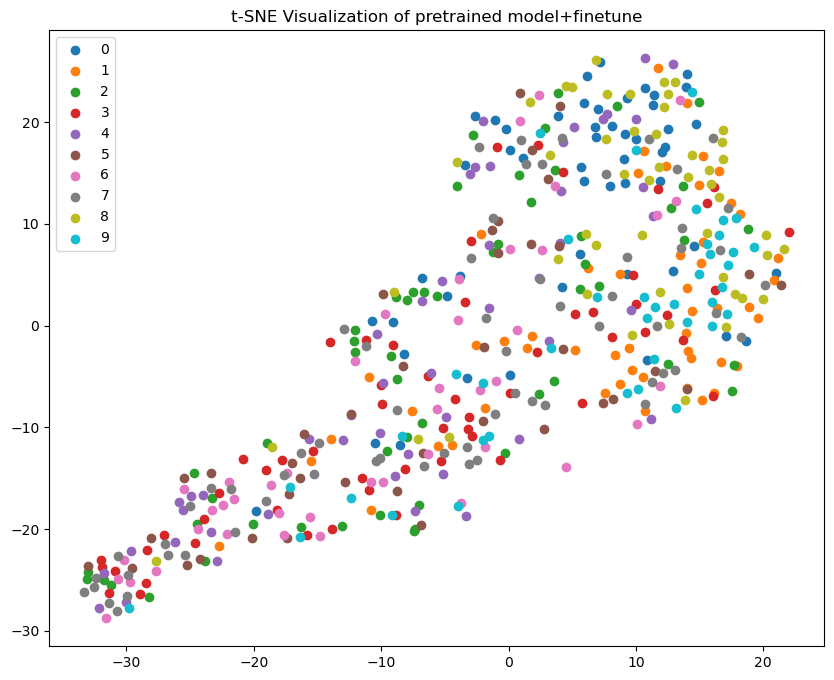

array([[ 9.08404350e+00,  1.48612251e+01],
       [ 2.01272583e+01,  4.01920366e+00],
       [-2.08790836e+01, -1.30727940e+01],
       [ 2.31838846e+00,  1.77690201e+01],
       [-1.74148636e+01, -1.44919052e+01],
       [ 1.43860760e+01,  2.29472961e+01],
       [-1.20701942e+01, -4.86766666e-01],
       [ 3.32561612e+00, -2.18143988e+00],
       [-1.69706993e+01, -1.35461922e+01],
       [ 1.05979977e+01,  1.71804924e+01],
       [ 9.67259502e+00, -9.62930083e-01],
       [ 9.30690885e-01,  2.00749321e+01],
       [-6.10900784e+00, -4.63370132e+00],
       [ 1.01842842e+01,  1.49945593e+01],
       [ 3.66349530e+00,  1.52808962e+01],
       [-3.22169924e+00, -1.19253330e+01],
       [-1.79863524e+00,  6.89149499e-01],
       [ 9.28245640e+00,  2.23238468e+01],
       [ 1.43056840e-01, -6.67867088e+00],
       [-3.19445400e+01, -2.37298870e+01],
       [-2.55045300e+01, -1.60336933e+01],
       [-2.54752407e+01, -1.49502516e+01],
       [ 1.38094435e+01,  8.41437912e+00],
       [-1.

In [6]:
types=["check"]
X=ExtractFeature(train_images,random_numbers,"check")
CheckFeature(X,"pretrained model+finetune")
#np.save("check.npy",X)

(500, 10)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


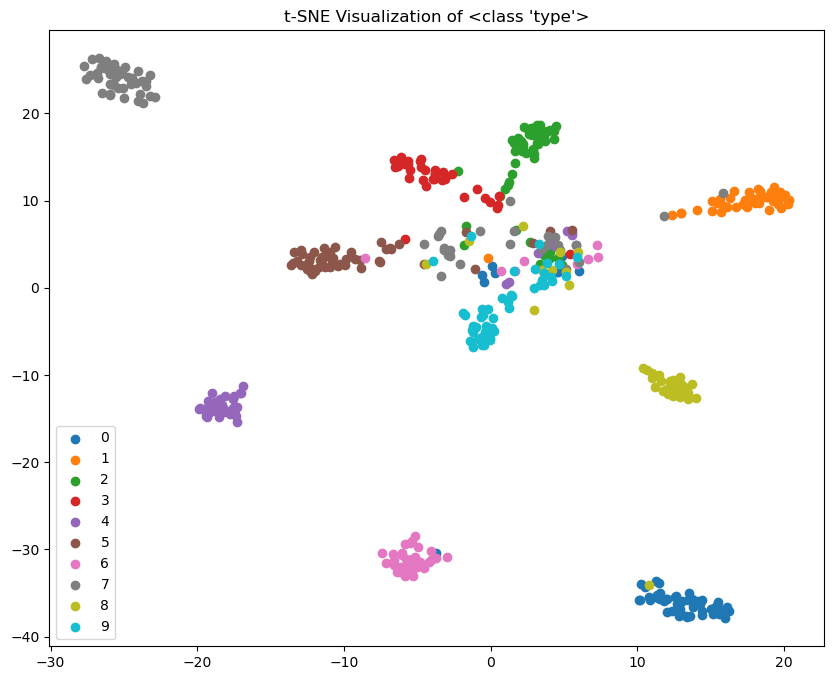

array([[ 7.47706175e-01, -1.13944423e+00],
       [ 1.25662174e+01, -3.54060211e+01],
       [ 2.24473691e+00,  3.07622766e+00],
       [-5.65311813e+00,  1.41716862e+01],
       [ 2.10177565e+00,  1.56240416e+01],
       [ 1.95480251e+01,  1.05153446e+01],
       [ 1.56555090e+01,  1.01282368e+01],
       [ 3.87908888e+00,  5.98658276e+00],
       [ 1.23954687e+01, -1.24244232e+01],
       [ 4.46297407e+00,  1.85931778e+00],
       [-2.62045498e+01,  2.60032825e+01],
       [ 1.22858393e+00,  1.20821667e+01],
       [-3.81705546e+00,  1.34887762e+01],
       [-3.09974265e+00,  1.24322319e+01],
       [ 1.21150770e+01, -1.21522112e+01],
       [-3.93384433e+00,  3.08420849e+00],
       [ 3.35458469e+00,  2.73798084e+00],
       [-2.75925217e+01,  2.39341755e+01],
       [-2.75559640e+00,  3.62652326e+00],
       [ 2.54745650e+00,  1.81958275e+01],
       [ 2.08936620e+00,  1.68735161e+01],
       [ 2.03279171e+01,  1.00424366e+01],
       [ 7.27342415e+00,  4.88065195e+00],
       [-1.

In [14]:
CheckFeature(X,type)

In [139]:
X=np.load('check.npy')
print(X.shape)
dist=euclidean_distances(X,X)
SS=SubsetSelection(X,250,dist)
start=time.time()
(C,value)=SS.ADMM_SparseModeling_bycvxpy(2e5,1)
np.save('C.npy',C)
print(time.time()-start)

(500, 10)
(10, 500)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 08 03:33:19 PM: Your problem has 250000 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 08 03:33:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 08 03:33:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 08 03:33:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


SolverError: The solver [<class 'cvxpy.atoms.geo_mean.geo_mean'>, <function pnorm at 0x00000187BA9D5B80>, <class 'cvxpy.atoms.pnorm.Pnorm'>, <class 'cvxpy.atoms.quad_form.QuadForm'>, <class 'cvxpy.atoms.quad_over_lin.quad_over_lin'>, <class 'cvxpy.atoms.elementwise.power.power'>, <class 'cvxpy.atoms.elementwise.huber.huber'>] is not installed.

## 直接取X和C，不用extract feature并跑算法

In [4]:
C=np.load('C.npy')
X=np.load('check.npy')

In [8]:
def FindMinByC(C,percent,p):
    [M,N]=np.array(C).shape
    norms = np.zeros(N)  # 存储列向量的q范数
    indices = np.arange(N)  # 列向量的索引
    top_k_indices = []  # 选择的列向量的索引
    for j in range(N):
        norm_vector=[x for x in C[j,:] ]
        norms[j] = np.linalg.norm(norm_vector, ord=p)
        if norms[j]>0.3:
            top_k_indices.append(j)
        #print("范数，根据范数从小到大选择",norms[j])
    # 根据列向量的q范数排序
    sorted_indices = np.argsort(norms)[::-1]
    # 选择排序后的前k个向量的索引
    top_k_indices1 = sorted_indices[:int(len(norms)*percent)]
    return top_k_indices1
def FindMinByCbycol(C,percent,p):
    [M,N]=np.array(C).shape
    norms = np.zeros(N)  # 存储列向量的q范数
    indices = np.arange(N)  # 列向量的索引
    top_k_indices = []  # 选择的列向量的索引
    for j in range(N):
        norm_vector=[x for x in C[:,j] ]
        norms[j] = np.linalg.norm(norm_vector, ord=p)
        if norms[j]>0.3:
            top_k_indices.append(j)
        #print("范数，根据范数从小到大选择",norms[j])
    # 根据列向量的q范数排序
    sorted_indices = np.argsort(norms)[::-1]
    # 选择排序后的前k个向量的索引
    top_k_indices1 = sorted_indices[:int(len(norms)*percent)]
    return top_k_indices1
def FindMinByC1(C,percent,p):
    [M,N]=np.array(C).shape
    norms = np.zeros(N)  # 存储列向量的q范数
    indices = np.arange(N)  # 列向量的索引
    top_k_indices = []  # 选择的列向量的索引
    for j in range(N):
        norm_vector=C[j, j]
        if norm_vector>0.2:
            top_k_indices.append(j)
    return top_k_indices
def FindMinByCnorm(C,percent,p):
    [M,N]=np.array(C).shape
    norms = np.zeros(N)  # 存储列向量的q范数
    indices = np.arange(N)  # 列向量的索引
    top_k_indices = []  # 选择的列向量的索引
    for j in range(N):
        norm_vector=[x for x in C[j,:] ]
        norms[j] = np.linalg.norm(norm_vector, ord=p)
    maxnorm=np.max(norms)
    threshold=maxnorm*percent
    for j in range(N):
        if norms[j]>threshold:
            top_k_indices.append(j)
    return top_k_indices


In [10]:
def compute_objective(X, C, indices):
    C_prime = calculate_C(X,indices)
    return np.linalg.norm(X-X.dot(C_prime),ord='fro')
def random_sampling(C,k):
    [M,N] = C.shape
    min_objective = float('inf')
    best_indices = []
    for _ in range(200000):
        indices = np.random.choice(X.shape[0], k, replace=False)
        objective = compute_objective(X, C, indices)

        if objective < min_objective:
            min_objective = objective
            best_indices = indices

    return best_indices
#效果不行
def greedy_algorithm(X, C, k):
    selected_indices = []
    remaining_indices = list(range(X.shape[0]))

    for _ in range(k):
        best_index = None
        min_objective = float('inf')

        for index in remaining_indices:
            current_indices = selected_indices + [index]
            objective = compute_objective(X, C, current_indices)

            if objective < min_objective:
                min_objective = objective
                best_index = index

        selected_indices.append(best_index)
        remaining_indices.remove(best_index)

    return selected_indices


## 绘制图像结果

In [15]:
import numpy as np

def simple_scatterplot(ax, X, labels, selected):
    tsne = TSNE(n_components=2, random_state=42, method='barnes_hut')
    X = tsne.fit_transform(X)
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    label_list=[]
    for label_index in range(len(labels)):
        if labels[label_index]==1:
            label_list.append(label_index)
        if label_index in selected:
            ax.scatter(X[label_index, 0], X[label_index, 1], s=80, color=colors(labels[label_index]),marker='*', edgecolors='black')
            ax.text(X[label_index, 0], X[label_index, 1], str(label_index), fontsize=7)
        else:
            ax.scatter(X[label_index, 0], X[label_index, 1], s=8, color=colors(labels[label_index]))
    print("label_list",label_list)
    X2=X[label_list]
    centr=X2.mean(axis=0)
    distances = np.linalg.norm(X2 - centr, axis=1)
    # 获取按距离中心点大小排序的索引（从大到小）
    sorted_indices = np.argsort(distances)[::-1]
    label_list = [label_list[i] for i in sorted_indices]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor((241/255, 241/255, 246/255))
    
    for spine in ax.spines.values():
        spine.set_edgecolor((159/255, 158/255, 180/255))
    ax.legend()
    return label_list



In [ ]:
[100000000]

In [67]:
X=np.load('check.npy')
print(X.shape)
dist=euclidean_distances(X,X)
SS=SubsetSelection(X,20,dist)
start=time.time()
(C,value)=SS.ADMM_SparseModeling_bycvxpy(2e5,np.inf)
np.save('C.npy',C)
print(time.time()-start)

(500, 10)
(10, 500)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 08 07:05:57 PM: Your problem has 250000 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 08 07:05:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 08 07:05:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 08 07:05:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 08 07:05:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) Sep 08 07:05:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [12]:
import numpy as np

def simple_scatterplot(ax, X, labels, selected,num):
    tsne = TSNE(n_components=2, random_state=42, method='barnes_hut')
    X = tsne.fit_transform(X)
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    label_list=[]
    for label_index in range(len(labels)):
        if labels[label_index]==num:
            label_list.append(label_index)
        if label_index in selected:
            ax.scatter(X[label_index, 0], X[label_index, 1], s=80, color=colors(labels[label_index]),marker='*', edgecolors='black')
            ax.text(X[label_index, 0], X[label_index, 1], str(label_index), fontsize=7)
        else:
            ax.scatter(X[label_index, 0], X[label_index, 1], s=8, color=colors(labels[label_index]))
    print("label_list",label_list)
    X2=X[label_list]
    centr=X2.mean(axis=0)
    distances = np.linalg.norm(X2 - centr, axis=1)
    # 获取按距离中心点大小排序的索引（从大到小）
    sorted_indices = np.argsort(distances)[::-1]
    label_list = [label_list[i] for i in sorted_indices]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor((241/255, 241/255, 246/255))
    
    for spine in ax.spines.values():
        spine.set_edgecolor((159/255, 158/255, 180/255))
    ax.legend()
    return label_list


In [10]:
lambdas=[20,50,100,250,500,1000,3000,5000,10000,50000,100000]
X=np.load('check.npy')
print(X.shape)
dist=euclidean_distances(X,X)
SS=SubsetSelection(X,20,dist)
start=time.time()
(C,value)=SS.ADMM_SparseModeling_bycvxpy(2e5,np.inf)
np.save('C.npy',C)

(500, 10)
(10, 500)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 08 07:33:45 PM: Your problem has 250000 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 08 07:33:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 08 07:33:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 08 07:33:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 08 07:33:45 PM: Compiling problem (target solver=ECOS).
(CVXPY) Sep 08 07:33:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

KeyboardInterrupt: 

lmd: 30


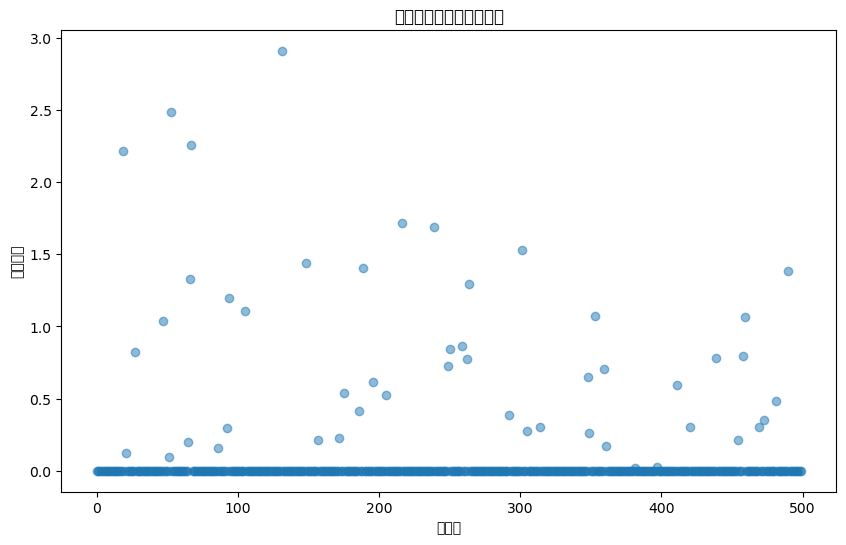

lmd: 35


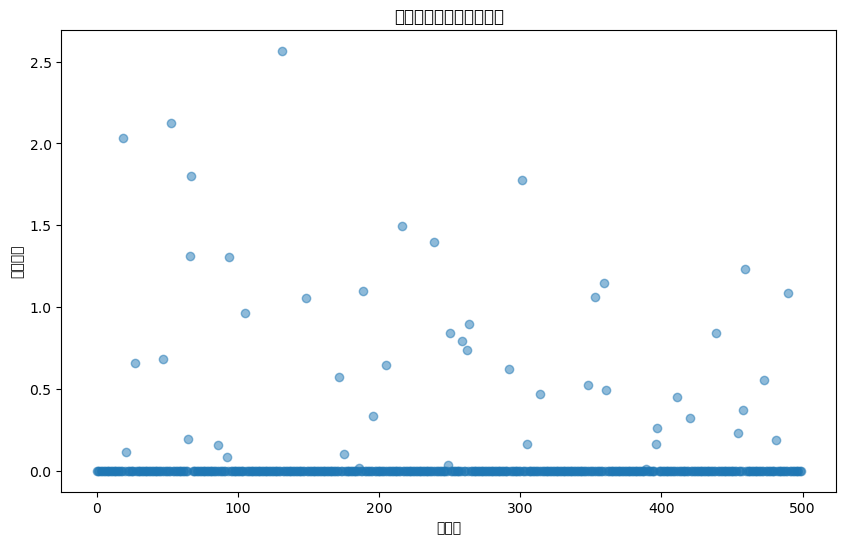

lmd: 40


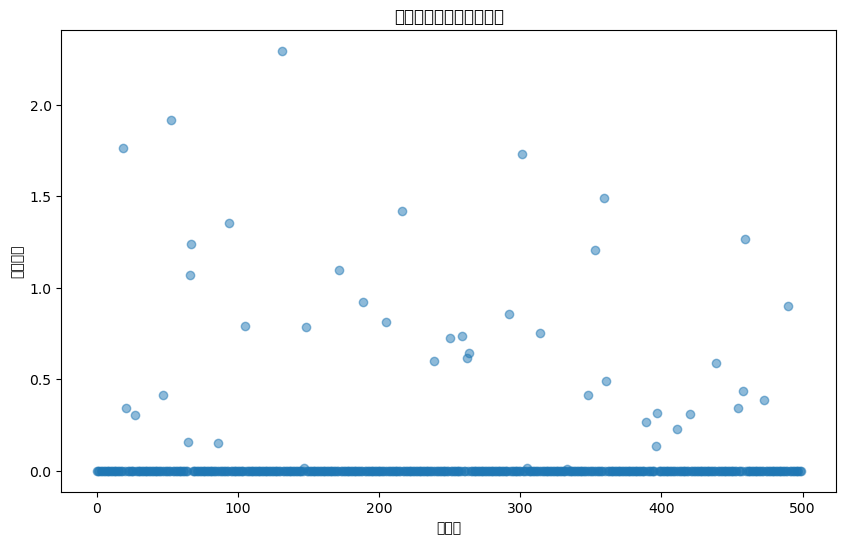

lmd: 45


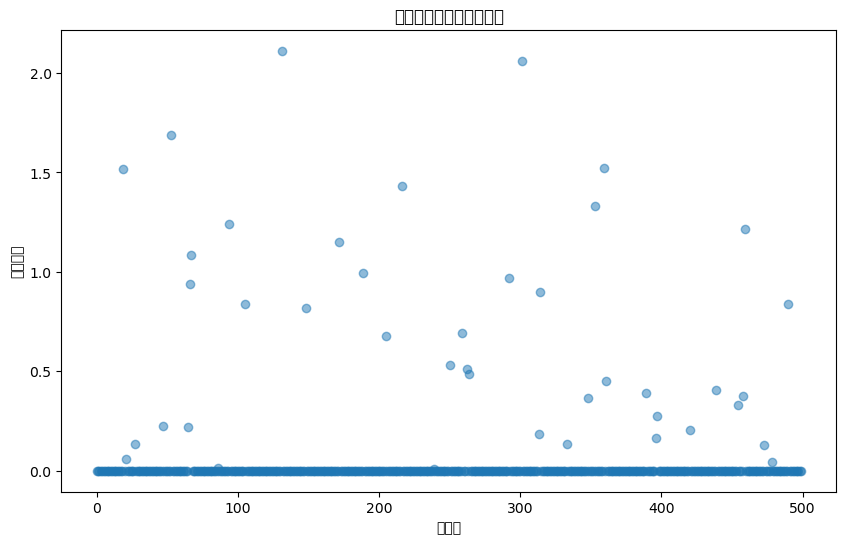

lmd: 50


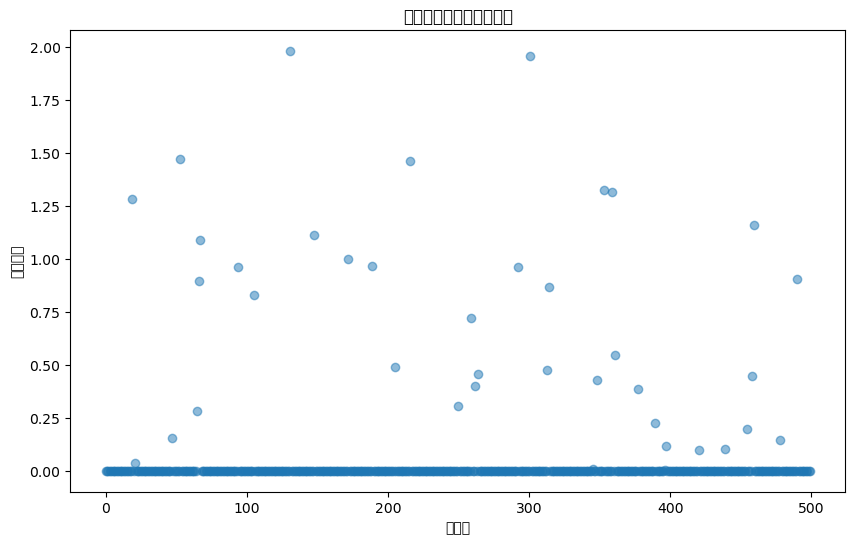

lmd: 55


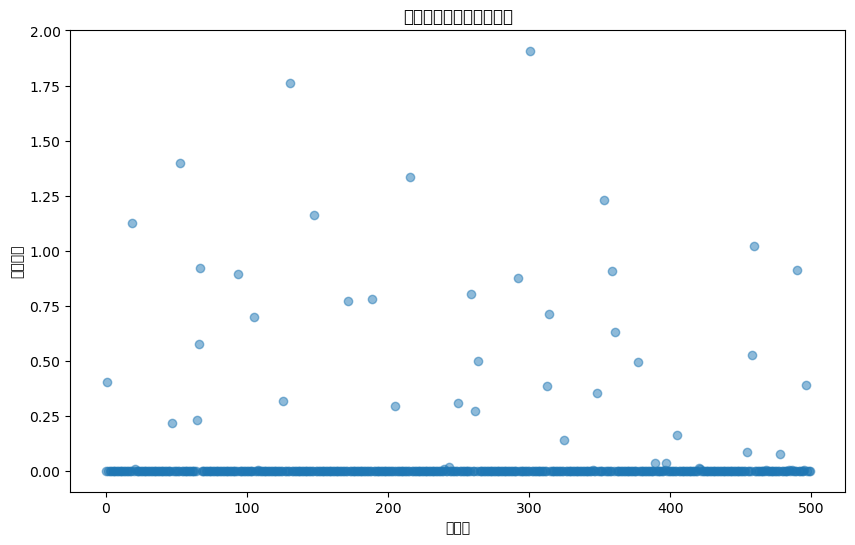

lmd: 60


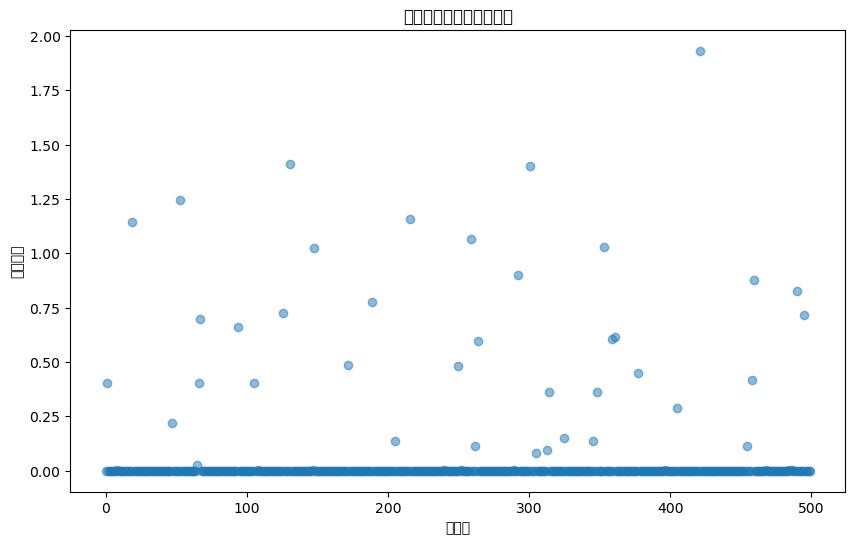

lmd: 65


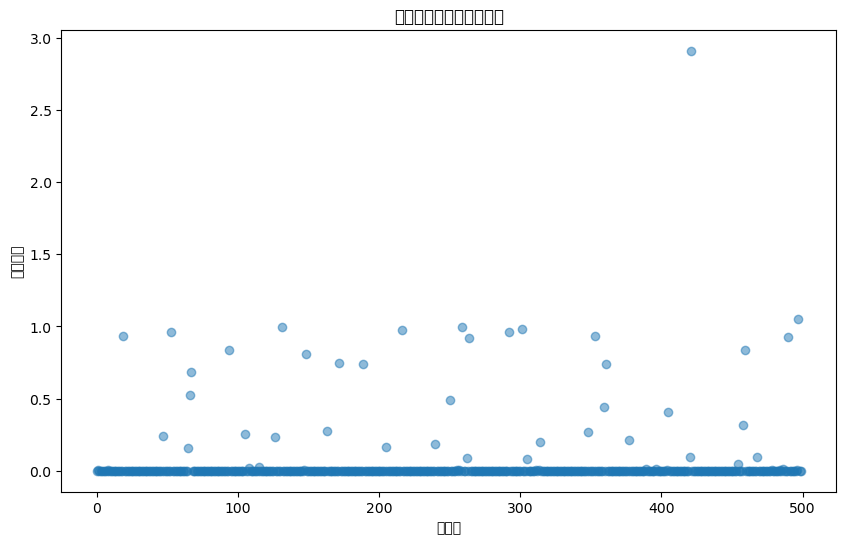

lmd: 70


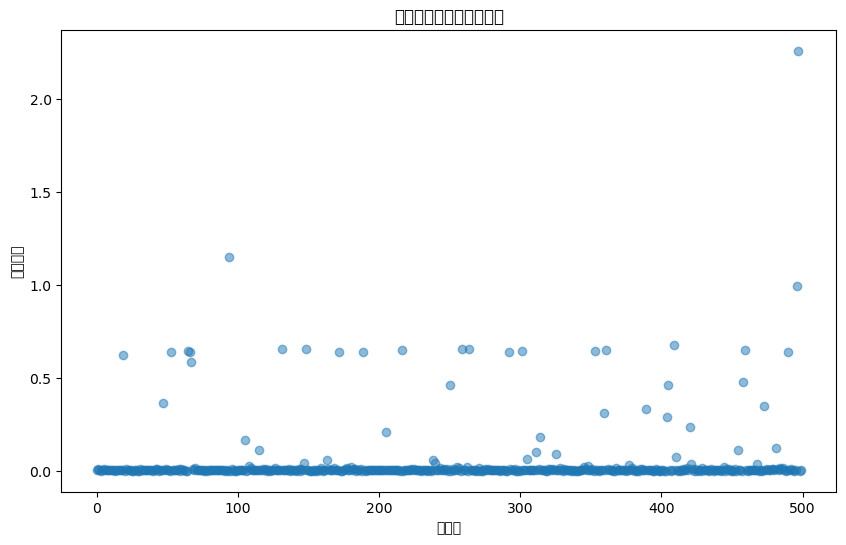

In [24]:
lambdas=[30,35,40,45,50,55,60,65,70]
for lmd in lambdas:
    print("lmd:",lmd)
    C=np.load(f'C_{lmd}.npy')
    data=[]
    result=FindMinByC(C,0.1,np.inf)
    for i in range(500):
        data.append(np.linalg.norm(C[i,:], ord=2))
    # 绘制散点图
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.scatter(range(500), data, alpha=0.5)  # alpha设置点的透明度，0为完全透明，1为完全不透明
    plt.xlabel('数据点')
    plt.ylabel('纵坐标值')
    plt.title('数据点的大小分布散点图')
    plt.show()

(500, 100)


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


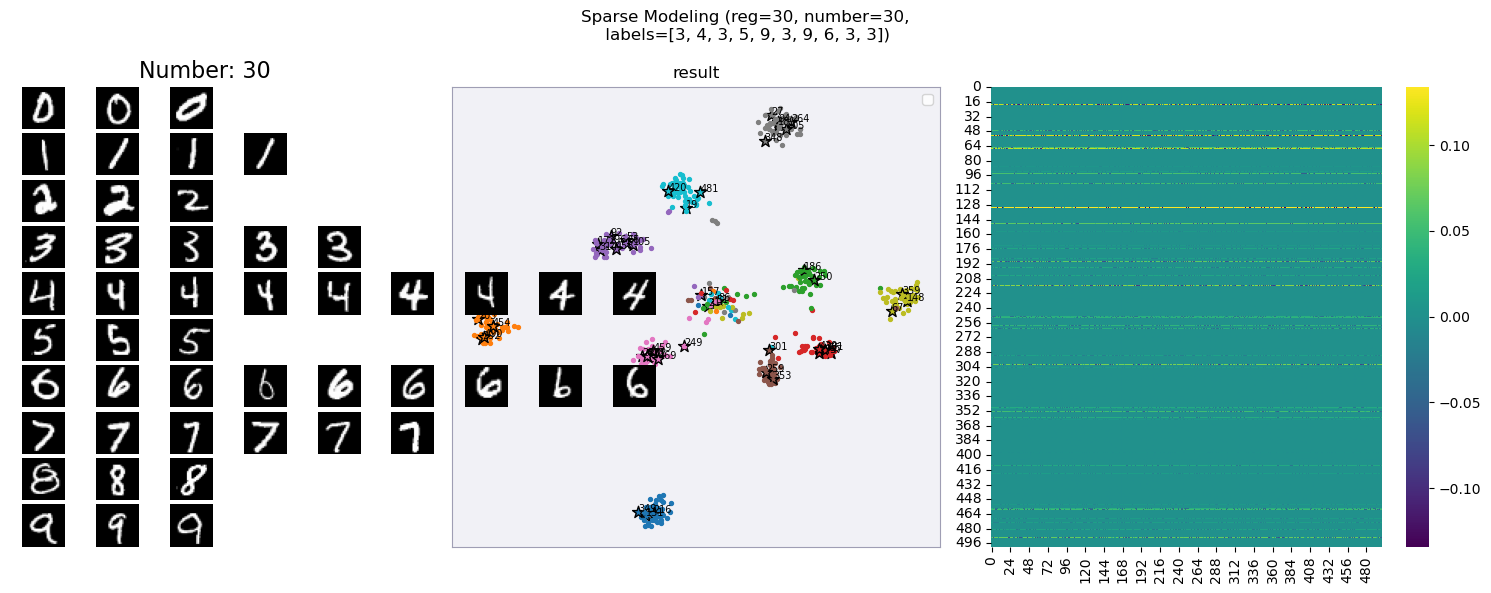

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


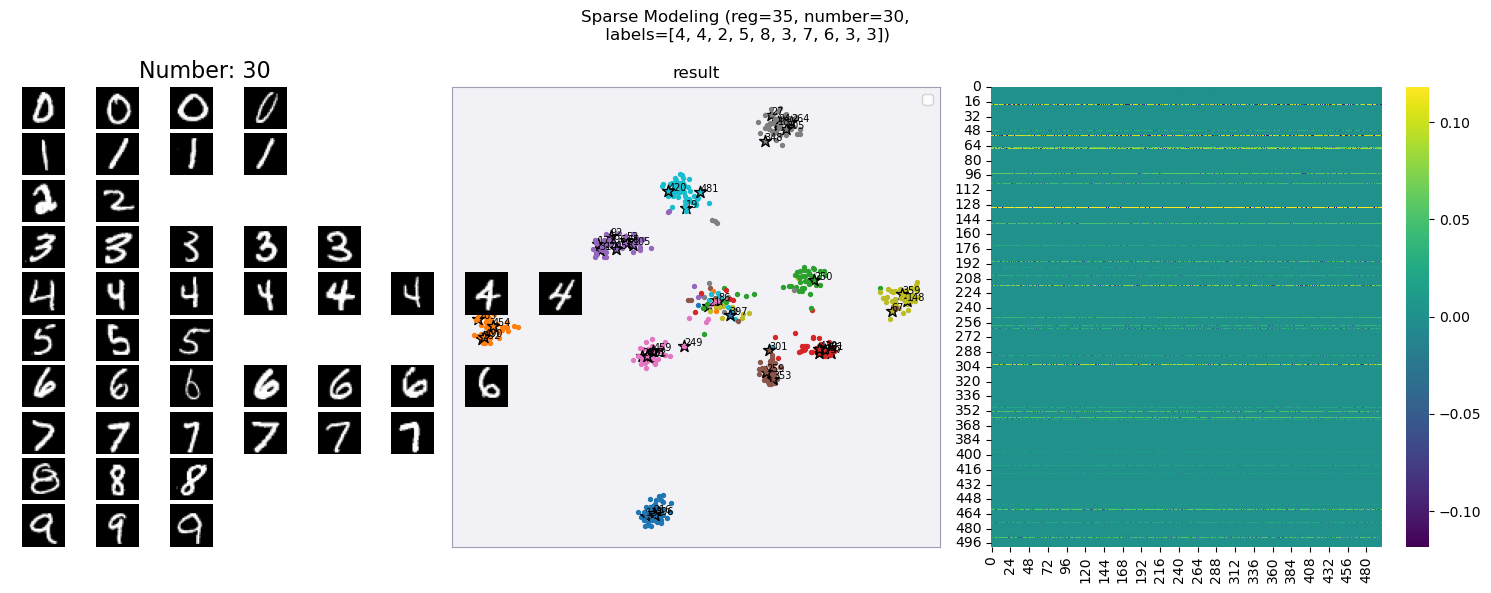

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


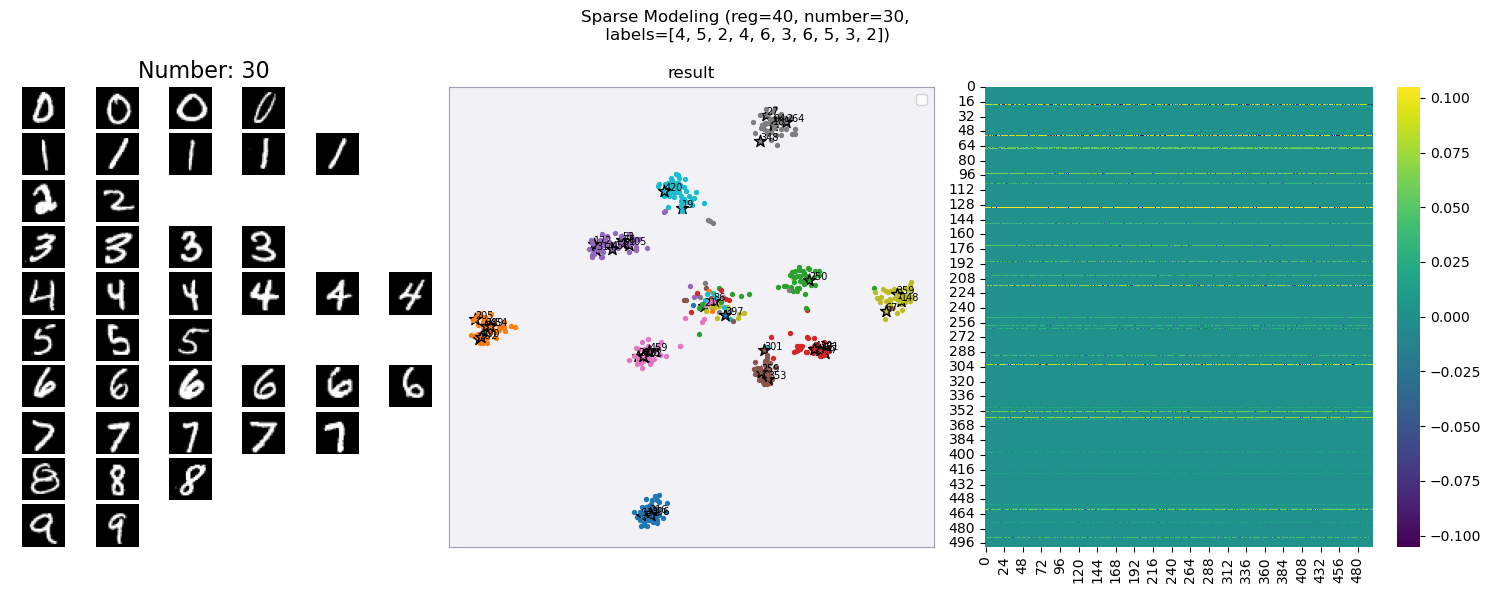

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


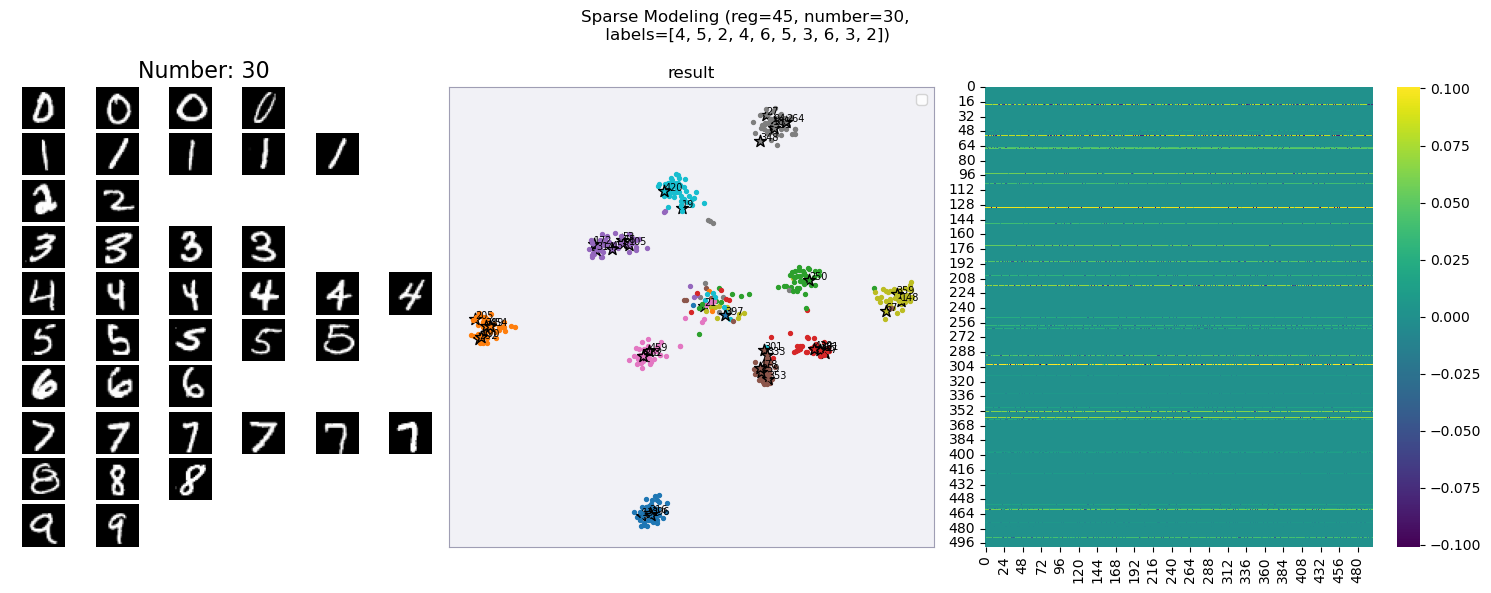

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


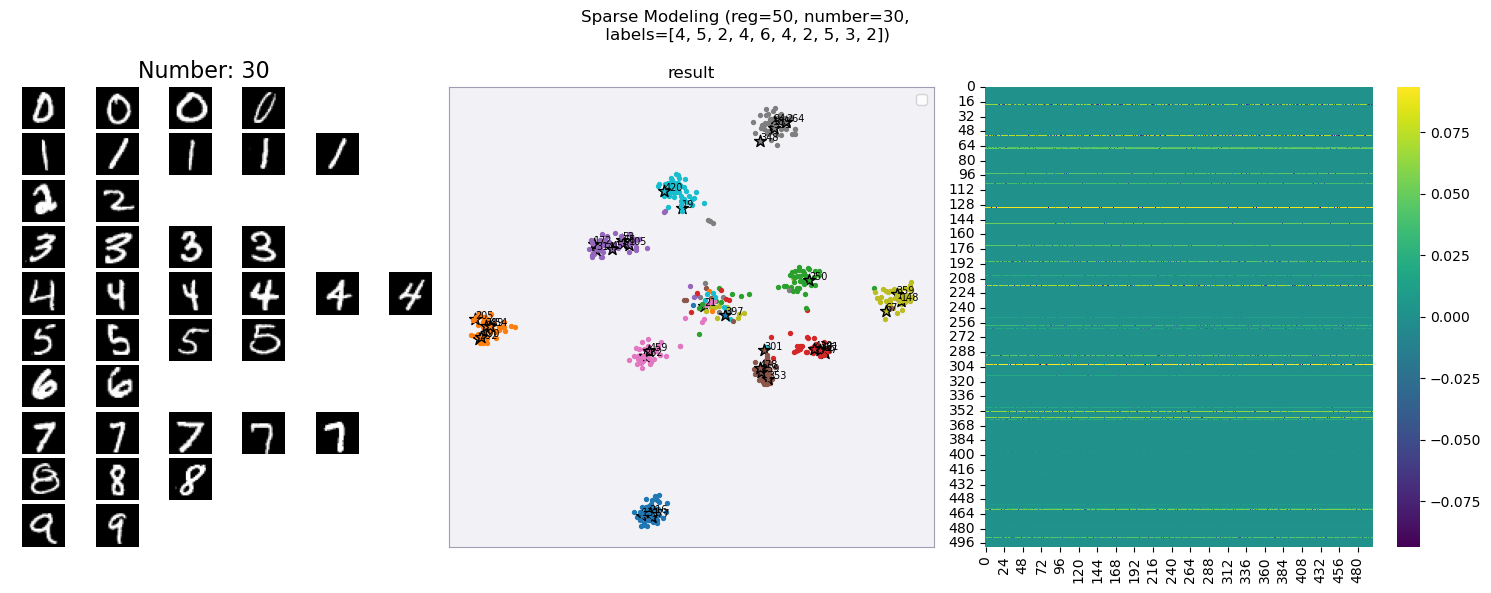

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


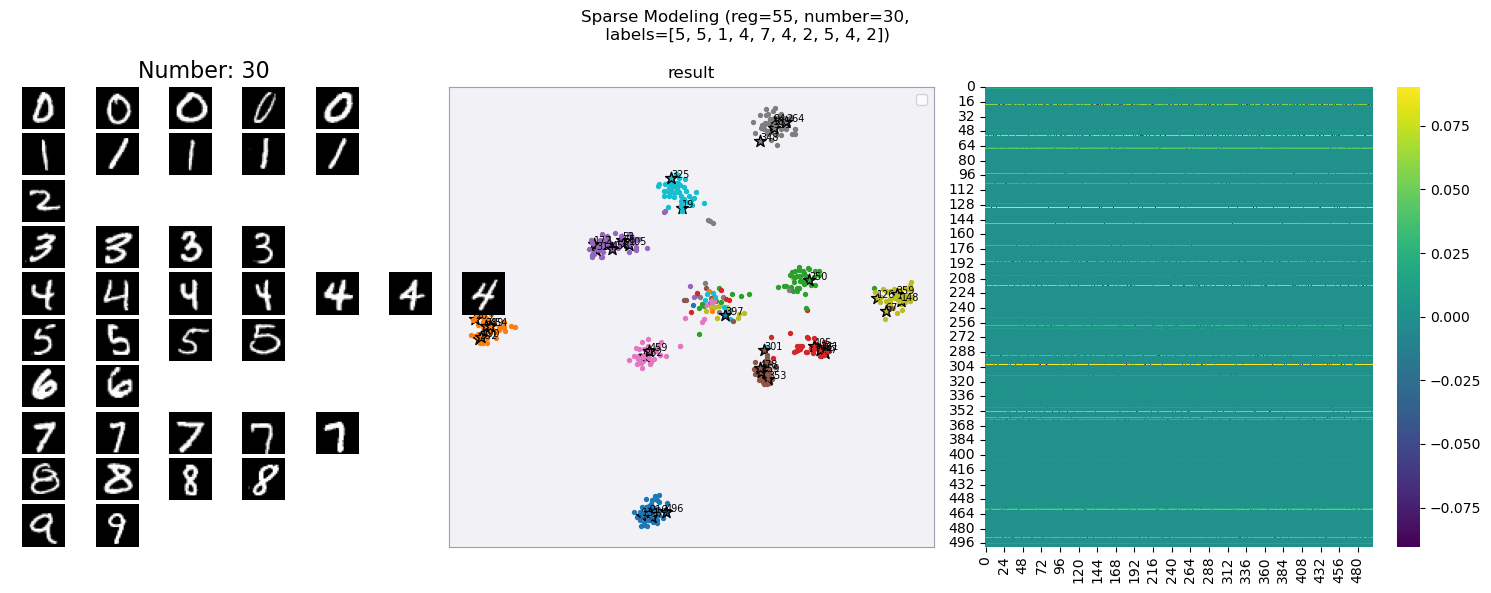

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


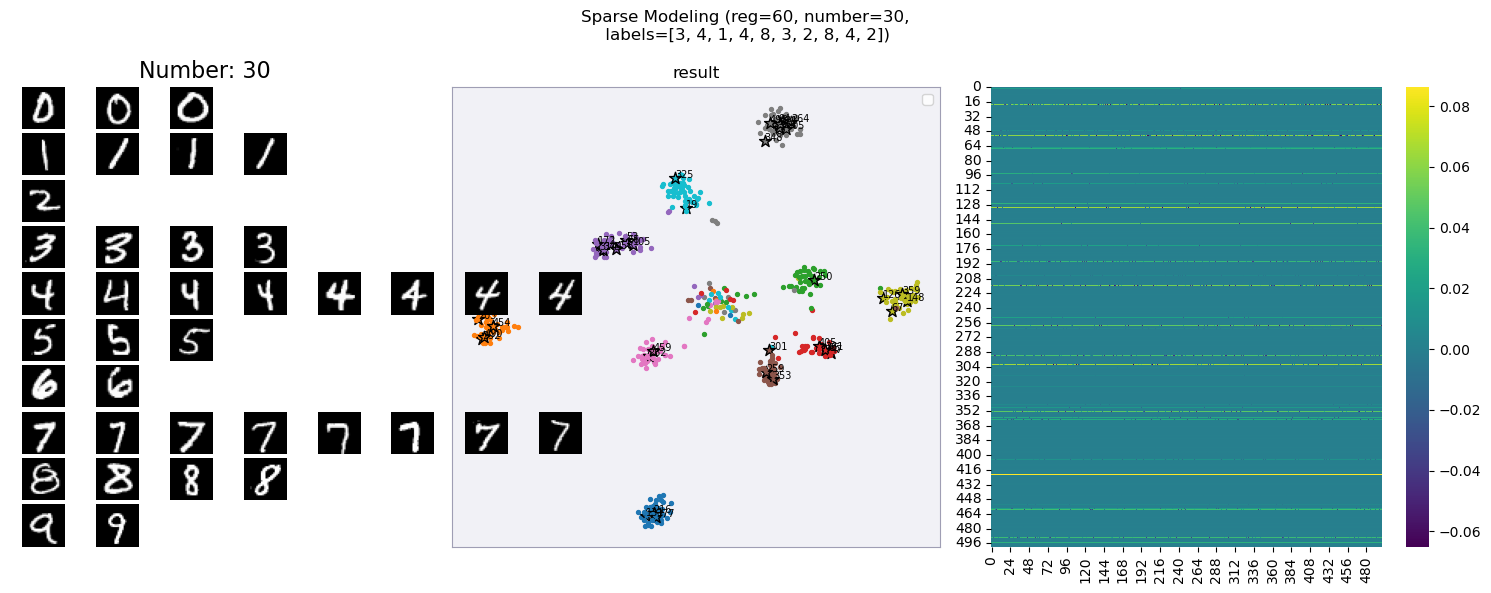

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


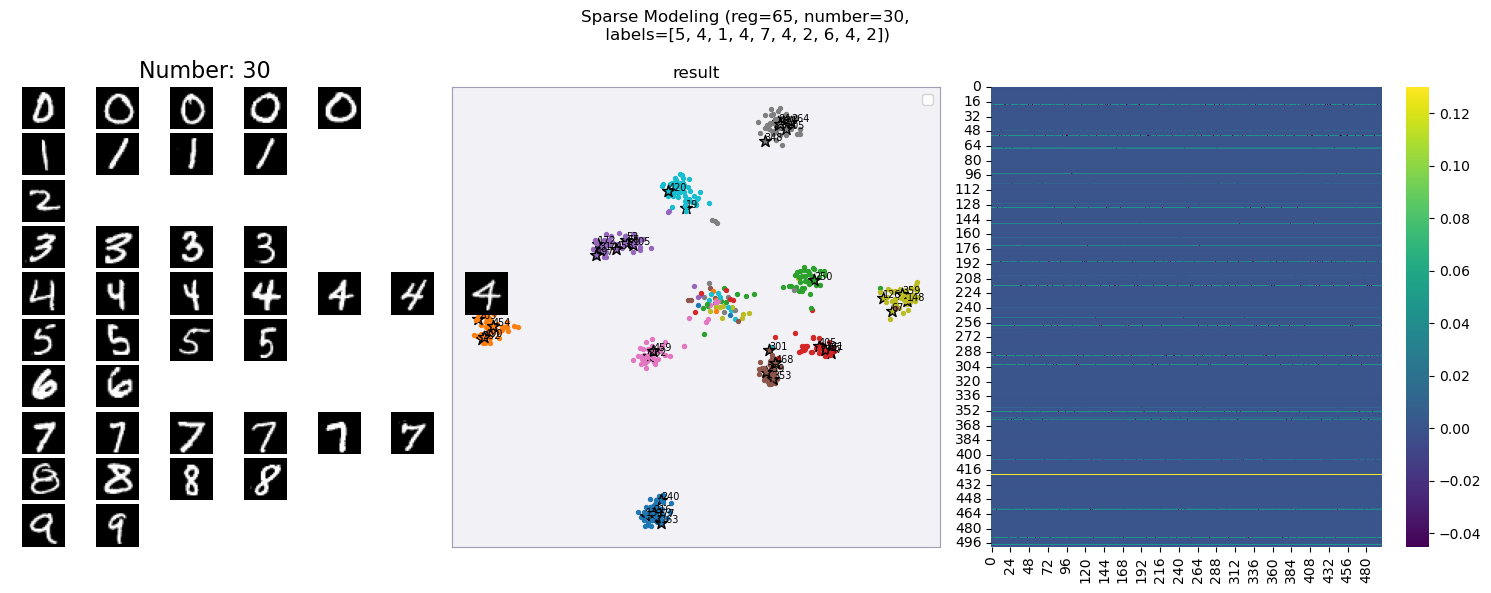

C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0, 0])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\3945383858.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [12, 15, 20, 32, 37, 46, 55, 58, 72, 73, 145, 165, 166, 174, 184, 203, 205, 224, 227, 229, 231, 253, 265, 268, 271, 277, 281, 292, 293, 299, 318, 319, 322, 329, 334, 342, 347, 389, 402, 406, 437, 444, 445, 448, 454, 470, 475, 490, 491, 499]


C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\liuyi\AppData\Local\Temp\ipykernel_63528\1492058908.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


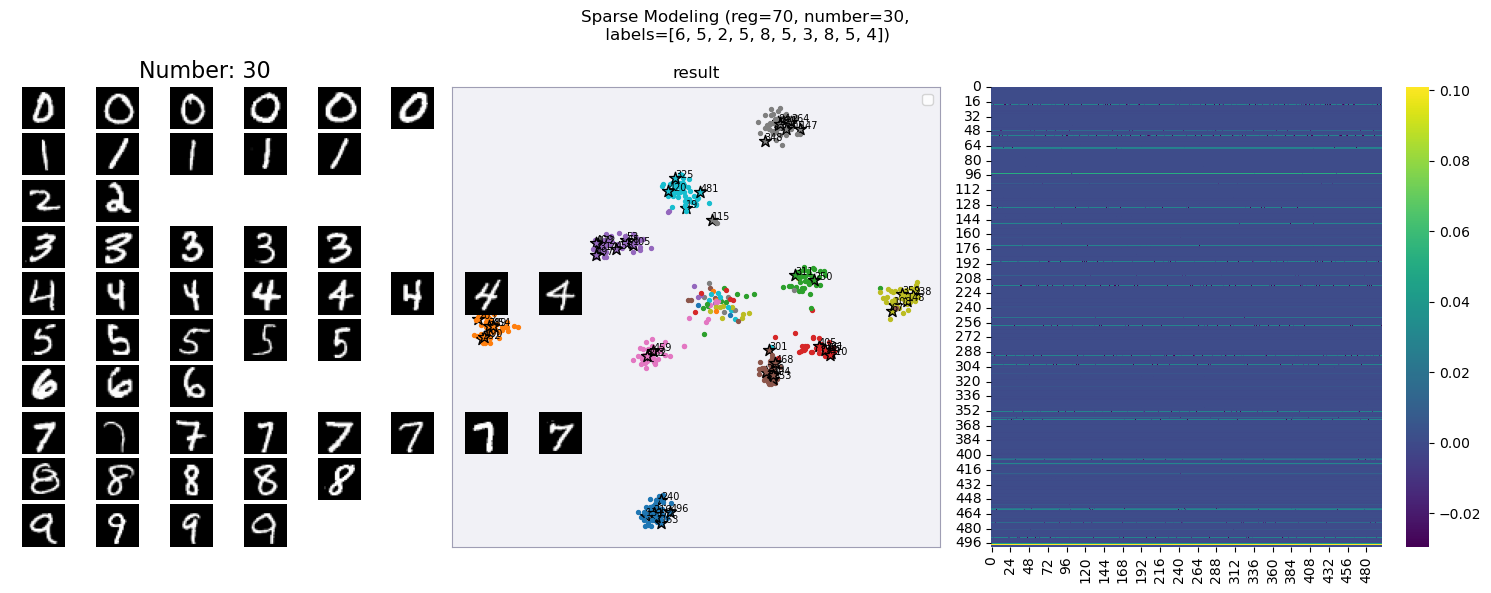

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
lambdas=[30,35,40,45,50,55,60,65,70]
print(X.shape)
dist=euclidean_distances(X,X)
for lambda_ in lambdas:
    C=np.load(f'C_{lambda_}.npy')
    # 创建主图和子图网格
    fig = plt.figure(figsize=(15, 6))

    # 创建主图
    gs_master = gridspec.GridSpec(1, 1)
    ax_master = plt.subplot(gs_master[0])

    # 创建子图网格，一行三列
    gs = gridspec.GridSpec(1, 3, width_ratios=[0.8, 1, 1])

    # 创建嵌套的子图
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    ax1.axis('off')

    sns.heatmap(C, cmap='viridis', ax=ax3)  # 第一个子图是热图

    # 绘制第二张图
    test_num=30
    result=FindMinByCnorm(C,0.01,np.inf)
    loss=100*np.linalg.norm(C,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C),ord='fro')
    target=np.linalg.norm(X.T-np.dot(X.T,C),ord='fro')
    labels = [0] * 10
    for index in result:
        labels[train_labels[index]] += 1
    # Plot result on the subplot
    SAMple=simple_scatterplot(ax2, X, train_labels[:1000], result)
    ax2.set_title('result')
    # Set the title
    fig.suptitle(f'Sparse Modeling (reg={lambda_}, number={int(test_num)},\n labels={labels})')
    # 在子图3中创建多行图像
    num_rows = 10
    num_cols = 20  # 你可以根据需要调整每行的列数
    result = FindMinByCnorm(C, 0.01, np.inf)
    labels = [0] * 10
    picture = [[] for _ in range(10)]
    for index in result:
        labels[train_labels[index]] += 1
        picture[train_labels[index]].append(train_images[index])

    # 创建嵌套的子图网格，包含多行图像
    gs_nested = gridspec.GridSpec(num_rows, num_cols, wspace=0.1, hspace=0.1)
    ax_nested = []

    # 在每个子图中使用imshow显示不同的图像
    for i in range(num_rows):
        for j in range(num_cols):
            if j < len(picture[i]):
                img = picture[i][j]
                ax_nested.append(fig.add_subplot(gs_nested[i, j]))
                ax_nested[-1].imshow(img, cmap='gray')
                ax_nested[-1].axis('off')

    # 设置图形标题和子图布局
    ax1.set_title(f'Number: {test_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

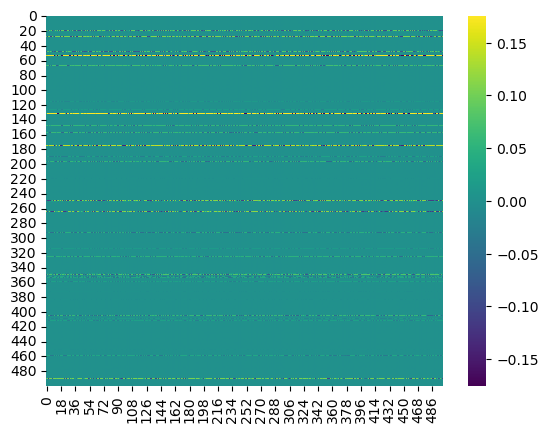

In [68]:
import seaborn as sns
# 创建热图
sns.heatmap(C, cmap='viridis')  # 使用 'viridis' 颜色映射，你可以根据需要更改
plt.show()

In [8]:
C= np.load('C.npy')
test_num=30
result=FindMinByC(C,test_num/500,np.inf)
print(result)
loss=100*np.linalg.norm(C,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C),ord='fro')
target=np.linalg.norm(X.T-np.dot(X.T,C),ord='fro')
print(target)
labels = [0] * 10
for index in result:
    labels[train_labels[index]] += 1
print(labels)
fig, axes = plt.subplots(1, 1, figsize=(6.5, 6.5))
# Plot result on the subplot
SAMple=simple_scatterplot(axes, X, train_labels[:1000], result)
print(SAMple)

axes.set_title('result')
# Set the title
fig.suptitle(f'Sparse Modeling (reg={100}, number={int(test_num)},\n labels={labels})')
plt.show()
np.save('result.npy',result)

NameError: name 'FindMinByC' is not defined

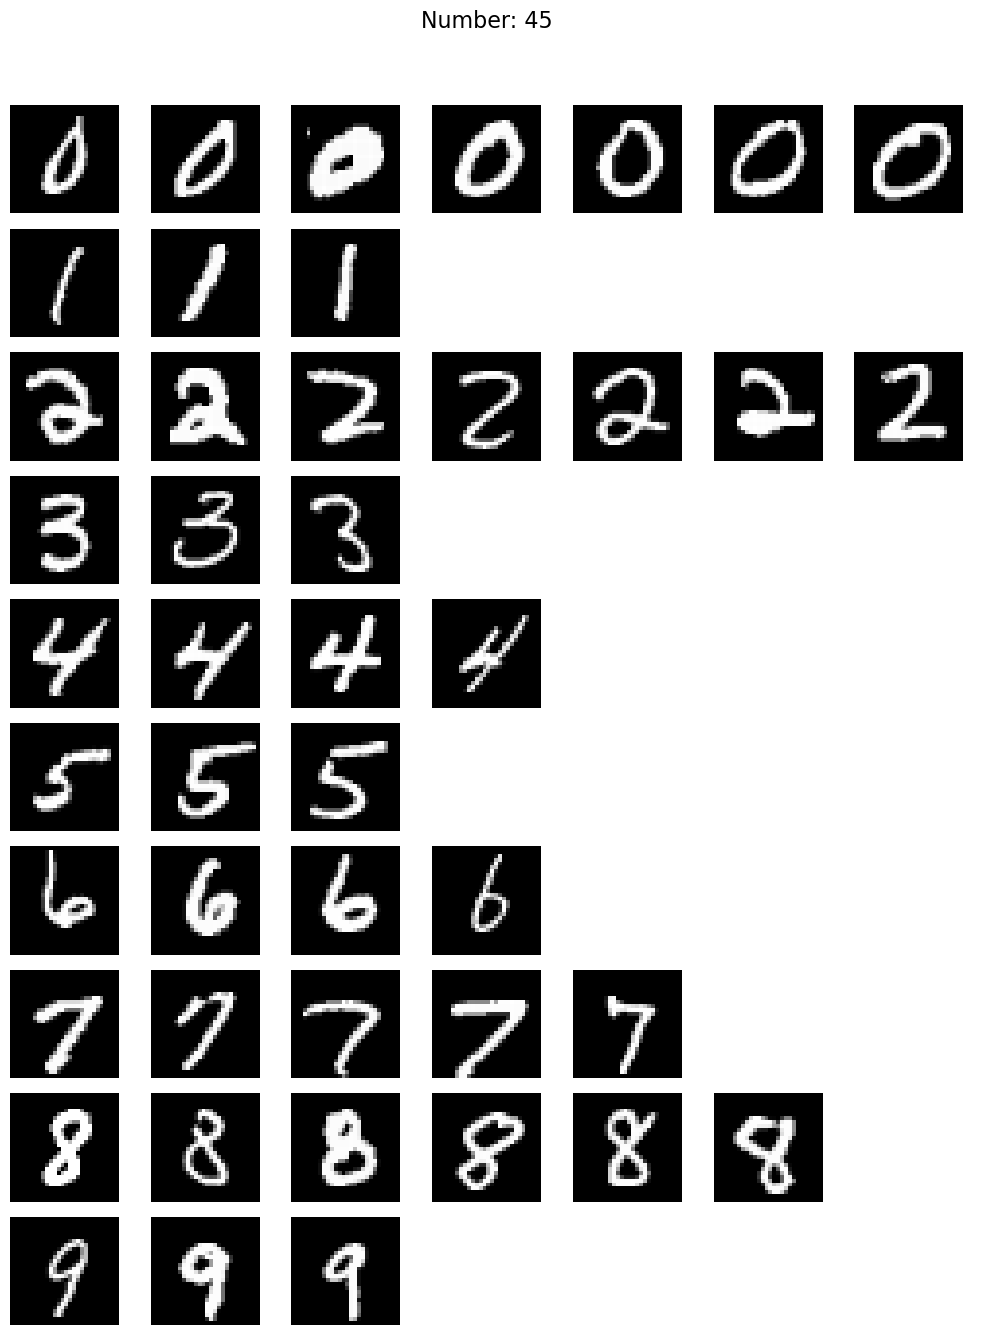

图像已保存至PDF文件： MNIST_Pictures_finetune.pdf


In [70]:
import random
pdf_filename = "MNIST_Pictures_finetune.pdf"
pdf_pages = PdfPages(pdf_filename)
# 设置每个图像的大小
image_size = (28, 28)
test_num=45
# 计算每行展示的列数
num_cols = 4
percent_list=[0.3]
for percent in percent_list:
    result = FindMinByC(C, test_num/500, np.inf)
    labels = [0]*10
    picture = [[] for _ in range(10)]
    for index in result:
        labels[train_labels[index]] += 1
        picture[train_labels[index]].append(train_images[index])

    # 计算每个图像在每行展示的列数
    max_cols = max(len(picture_cu) for picture_cu in picture)
    num_cols = max(num_cols, max_cols)  # 限制最大列数为10
    num_cols=min(num_cols,20)
    # 计算每个图像的缩放比例
    scale_factor = image_size[0] / (num_cols * image_size[1])

    # 创建一个带有多个子图的图形
    fig, axes = plt.subplots(10, num_cols, figsize=(10, 14))
    # 在每个子图中使用imshow显示不同的图像
    for i, picture_cu in enumerate(picture):
        if len(picture_cu) > 20:
            picture_cu = random.sample(picture_cu, 20)
        for j in range(num_cols):
            if j < len(picture_cu):
                img = picture_cu[j]
                axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    # 设置图形标题和子图布局
    fig.suptitle(f'Number: {test_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 保存图形到PDF文件
    pdf_pages.savefig(fig)

# 关闭PDF文件
pdf_pages.close()
plt.show()
print("图像已保存至PDF文件：", pdf_filename)


## 微调result

In [5]:
import cvxpy as cp
def calculate_C_bycp(Y,combination):
        [M, N] = np.shape(Y)
        C = cp.Variable((N, N))
        newcombination = [i for i in range(N) if i not in combination]
        # 定义两个约束
        constraint1 = cp.sum(C,axis=0) == 1
        constraint2= C[newcombination,:]==0
        # 将约束放入 constraints 列表
        constraints = [constraint1,constraint2]

        # 构建目标函数
        obj = cp.Minimize( cp.norm(Y - Y @ C, "fro"))

        # 创建问题实例
        problem = cp.Problem(obj, constraints)
        # 求解问题
        problem.solve(abstol=1e-5,reltol=1e-5, feastol=1e-5,verbose=False)
        return C.value,problem.value

### 删减某些点loss值

In [72]:
C_=calculate_C_bycp(X.T,result)[0]
Y_YC=np.linalg.norm(X.T-X.T.dot(C_),ord='fro')
loss_list=[]
for i in result:
    result1=[x for x in result if x !=i ] 
    C1=calculate_C_bycp(X.T,result1)[0]
    Y_YC1=np.linalg.norm(X.T-X.T.dot(C1),ord='fro')
    loss_list.append((i,Y_YC1))
up_loss_list=[x for x in loss_list if x[1]>Y_YC]
down_loss_list=[x for x in loss_list if x[1]<=Y_YC]
sorted_up_loss_list=sorted(up_loss_list,key=lambda x:x[1],reverse=True)
sorted_down_loss_list=sorted(down_loss_list,key=lambda x:x[1],reverse=False)

print(Y_YC,sorted_down_loss_list)

5.883412844532024e-09 []


In [75]:
import pandas as pd

# 您提供的数据点
data = sorted_up_loss_list
# 创建一个DataFrame
df = pd.DataFrame(data, columns=['数据点', 'Y-YC\''])

# 设置Y-YC列的值为0.00033
df['Y-YC'] = 5.883412844532024e-09

# 设置增减情况列的值为"上升"
df['增减情况'] = '上升'

# 将DataFrame保存到Excel文件
excel_file = '优化结果.xlsx'
df.to_excel(excel_file, index=False)

print(f"数据已保存到 {excel_file}")


数据已保存到 优化结果.xlsx


### 添加某些应该加入的点，loss值

In [28]:
C_=calculate_C_bycp(X.T,result)[0]
Y_YC=np.linalg.norm(X.T-X.T.dot(C_),ord='fro')
print(Y_YC)
datapoint=[58,176,282  ,5,485,186,   449,374,314,   84,244,365,   274,428,   426,192,39,  104,46,  303,41]
loss_list=[]
for i in datapoint:
    result1=[x for x in result]
    result1.append(i)
    C1=calculate_C_bycp(X.T,result1)[0]
    Y_YC1=np.linalg.norm(X.T-X.T.dot(C1),ord='fro')
    loss_list.append((i,Y_YC1))
up_loss_list=[x for x in loss_list if x[1]>Y_YC]
down_loss_list=[x for x in loss_list if x[1]<=Y_YC]
sorted_up_loss_list=sorted(up_loss_list,key=lambda x:x[1],reverse=True)
sorted_down_loss_list=sorted(down_loss_list,key=lambda x:x[1],reverse=False)
print(sorted_up_loss_list)

8.566056314196735e-10
[]


<Figure size 640x480 with 0 Axes>

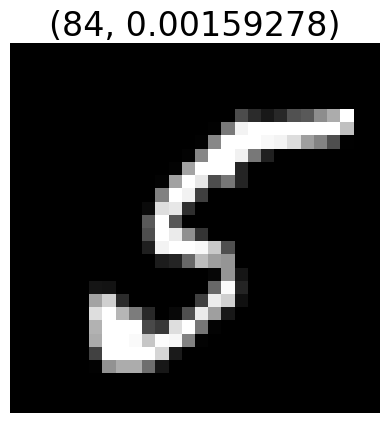

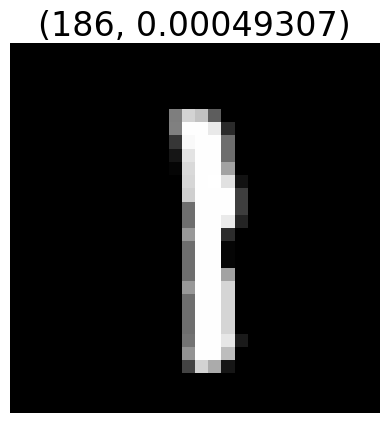

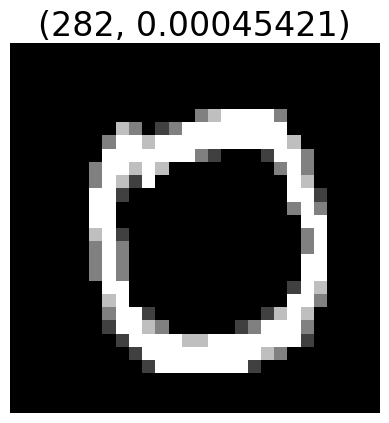

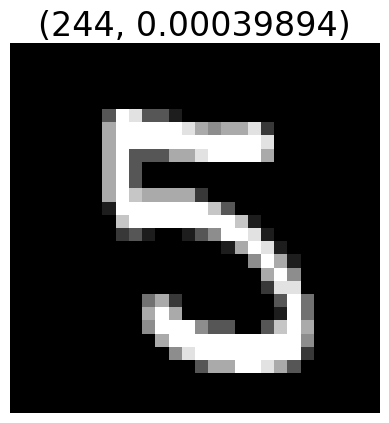

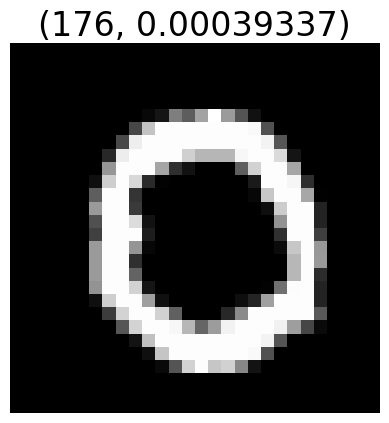

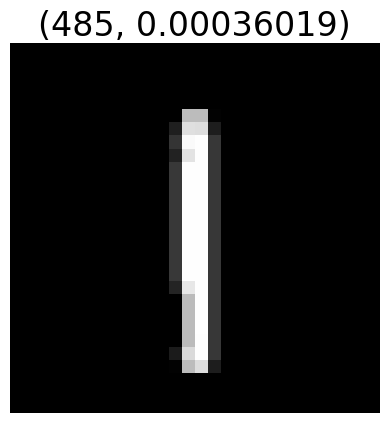

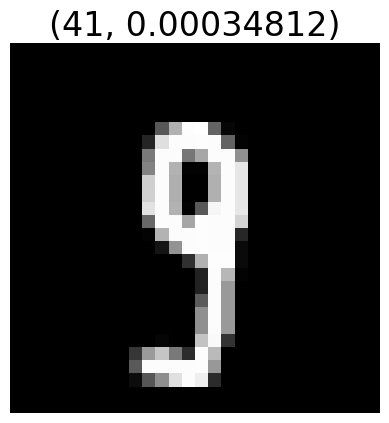

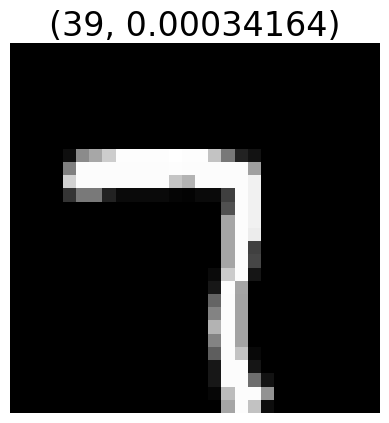

In [30]:
index_list=[x[0] for x in sorted_up_loss_list]
loss_list=[x[1] for x in sorted_up_loss_list]
# 创建一个带有多个子图的图形
picture = []
for index in sorted_up_loss_list:
    picture.append(train_images[index[0]])
plt.figure()
for picture_cu, index in enumerate(sorted_up_loss_list):
    img = train_images[index[0]]
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f'{index[0],round(index[1],8)}', fontsize=24)
    plt.axis('off')
    plt.show()

In [19]:
import pandas as pd

# 您提供的数据点
data = sorted_down_loss_list
# 创建一个DataFrame
df = pd.DataFrame(data, columns=['数据点', 'Y-YC\''])

# 设置Y-YC列的值为0.00033
df['Y-YC'] = 0.0003353
# 设置增减情况列的值为"上升"
df['增减情况'] = '下降'

# 将DataFrame保存到Excel文件
excel_file = '优化结果.xlsx'
df.to_excel(excel_file, index=False)

print(f"数据已保存到 {excel_file}")

数据已保存到 优化结果.xlsx


### 对result1列表中的所有元素展示其覆盖点的最大数量级和范围

170 1 -10 0.9999999562996161 0.9999999562996161
397 32 -10 0.9999999342977631 0.9999999342977631
148 1 -10 0.999999932901837 0.999999932901837
205 21 -11 0.9999999723356352 0.9999999723356352


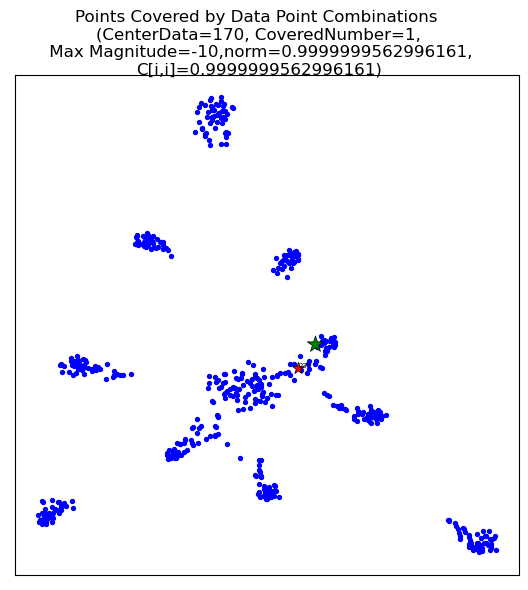

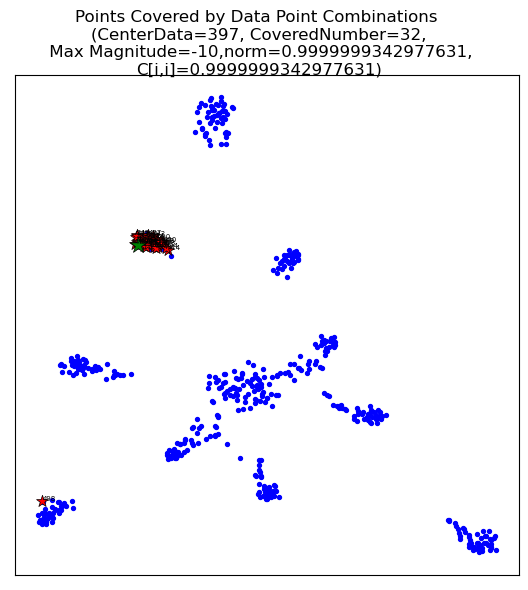

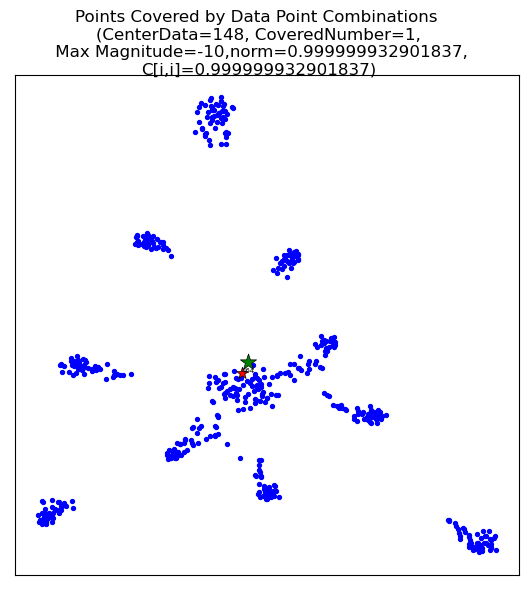

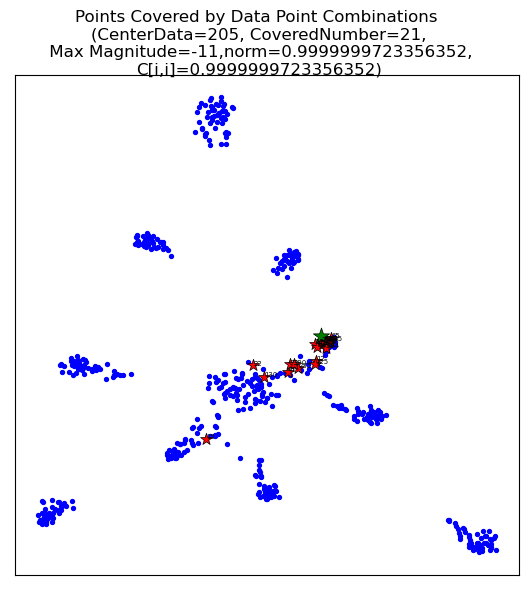

In [77]:
result1=[170,397,148,205]
for index in result1:
    max_magnitude = float('-inf')  # 初始化最大数量级
    max_magnitude_indices = []  # 初始化最大数量级的索引列表
    test_num=index
    vector=C[test_num,:]
    magnitude_indices = {}  # 创建一个字典来存储不同数量级的索引列表

    for i, num in enumerate(vector):
        magnitude = int(np.floor(np.log10(np.abs(num))))  # 计算数量级并转换为整数
        if magnitude == -1:
            if num>0.9:
                continue
        if magnitude in magnitude_indices:
            magnitude_indices[magnitude].append(i)
        else:
            magnitude_indices[magnitude] = [i]
    
    # 提取数量级相同的索引列表
    max_magnitude_indices = magnitude_indices[max(magnitude_indices.keys())]
    norm_vector=[x for x in vector ]
    print(index,len(max_magnitude_indices),magnitude,np.linalg.norm(norm_vector,ord=np.inf),norm_vector[index])
    tsne = TSNE(n_components=2, random_state=42, method='barnes_hut')
    X1 = tsne.fit_transform(X)
    fig,axes =plt.subplots(1, 1, figsize=(6.5, 6.5))
    # 隐藏横坐标和纵坐标
    plt.xticks([])  # 隐藏X轴刻度
    plt.yticks([])  # 隐藏Y轴刻度
    axes.scatter(X1[:, 0], X1[:, 1], s=8, color='blue')
    axes.scatter(X1[max_magnitude_indices, 0], X1[max_magnitude_indices, 1], s=80, color='red',marker='*', edgecolors='black', linewidth=0.5)
    axes.scatter(X1[test_num, 0], X1[test_num, 1], s=150, color='green',marker='*', edgecolors='black', linewidth=0.5)
    # Set the title
    fig.suptitle(f'Points Covered by Data Point Combinations \n(CenterData={index}, CoveredNumber={int(len(max_magnitude_indices))},\n Max Magnitude={magnitude},norm={np.linalg.norm(norm_vector,ord=np.inf)},\nC[i,i]={norm_vector[index]})')
    for i in max_magnitude_indices:
        axes.text(X1[i, 0], X1[i, 1], i, fontsize=5, color='black')

[301, 322, 470, 195]


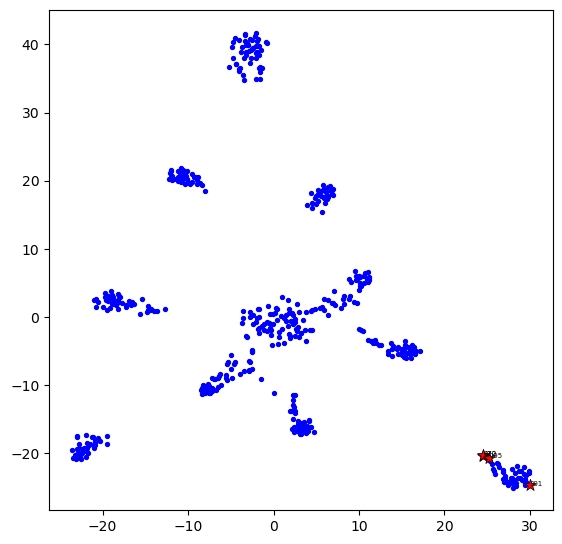

In [94]:
#print(SAMple,len(result))
SAMple=[470, 322, 195,301]
X2=X[SAMple]
centr=X2.mean(axis=0)
#print(centr)
np.append(X,centr)
distances = np.linalg.norm(X2 - centr, axis=1)
# 获取按距离中心点大小排序的索引（从大到小）
sorted_indices = np.argsort(distances)[::-1]
#print(sorted_indices)
index_list=[]
for i in range(4):
    index_list.append(SAMple[sorted_indices[i]])
    #print(index_list,sorted_indices[i])
print(index_list)
result1=set(result)-set(SAMple)|set(index_list)
#print(result,len(result))
tsne = TSNE(n_components=2, random_state=42, method='barnes_hut')
X1 = tsne.fit_transform(X)
fig,axes =plt.subplots(1, 1, figsize=(6.5, 6.5))
axes.scatter(X1[:, 0], X1[:, 1], s=8, color='blue')
axes.scatter(X1[index_list, 0], X1[index_list, 1], s=80, color='red',marker='*', edgecolors='black', linewidth=0.5)
for i in index_list:
    axes.text(X1[i, 0], X1[i, 1], i, fontsize=5, color='black')


plt.show()

## 找某个数字全部外围点比较值

In [ ]:
result=np.load('result.npy')
result.sort()
#X2为某数字全部样本
X2=X[SAMple]
#找到某数字全部样本的最外围点
centr=X2.mean(axis=0)
#print(centr)
np.append(X,centr)
distances = np.linalg.norm(X2 - centr, axis=1)
sorted_indices = np.argsort(distances)[::-1]
index_list=[]
for i in range(8):
    index_list.append(SAMple[sorted_indices[i]])
#将最外围点加入到result中
result1=list(set(result)-set(SAMple)|set(index_list))
result1.sort()
print(C.shape)
C1=np.zeros_like(C)
C1[:,result]=C[:,result]
print(C1.shape)
C2=np.zeros_like(C)
C2[:,result1]=C[:,result1]
loss1=np.linalg.norm(X.T-X.T.dot(C1),ord='fro')
loss2=np.linalg.norm(X.T-X.T.dot(C2),ord='fro')
print(loss1,loss2)

In [102]:
C=np.load('C.npy')
X=np.load('check.npy')
result=np.load('result.npy')

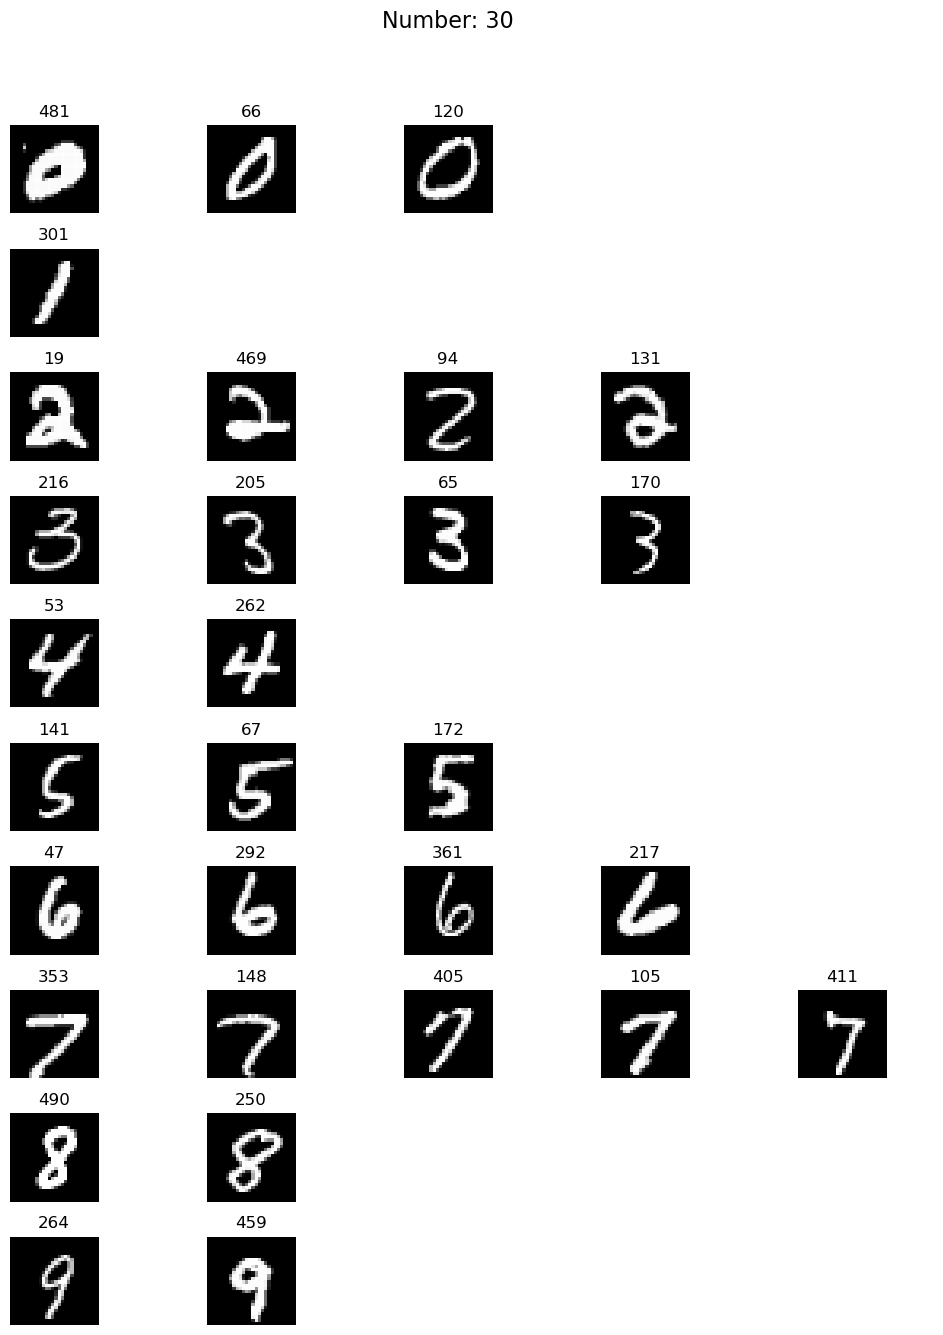

图像已保存至PDF文件： MNIST_Pictures_finetune.pdf


In [94]:

import random
pdf_filename = "MNIST_Pictures_finetune.pdf"
pdf_pages = PdfPages(pdf_filename)
# 设置每个图像的大小
image_size = (28, 28)
test_num=30
# 计算每行展示的列数
num_cols = 4
percent_list=[0.3]
for percent in percent_list:
    result = FindMinByC(C, test_num/500, np.inf)
    labels = [0]*10
    picture = [[] for _ in range(10)]
    picture_index = [[] for _ in range(10)]
    for index in result:
        labels[train_labels[index]] += 1
        picture[train_labels[index]].append(train_images[index])
        picture_index[train_labels[index]].append(index)
    # 计算每个图像在每行展示的列数
    max_cols = max(len(picture_cu) for picture_cu in picture)
    num_cols = max(num_cols, max_cols)  # 限制最大列数为10
    num_cols=min(num_cols,20)
    # 计算每个图像的缩放比例
    scale_factor = image_size[0] / (num_cols * image_size[1])

    # 创建一个带有多个子图的图形
    fig, axes = plt.subplots(10, num_cols, figsize=(10, 14))
    # 在每个子图中使用imshow显示不同的图像
    for i, picture_cu in enumerate(picture):
        if len(picture_cu) > 20:
            picture_cu = random.sample(picture_cu, 20)
        for j in range(num_cols):
            if j < len(picture_cu):
                img = picture_cu[j]
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].title.set_text(f'{picture_index[i][j]}')
            axes[i, j].axis('off')
    # 设置图形标题和子图布局
    fig.suptitle(f'Number: {test_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 保存图形到PDF文件
    pdf_pages.savefig(fig)

# 关闭PDF文件
pdf_pages.close()
plt.show()
print("图像已保存至PDF文件：", pdf_filename)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


label_list [1, 9, 24, 37, 38, 58, 60, 66, 72, 75, 78, 92, 108, 120, 130, 140, 151, 157, 159, 163, 171, 176, 183, 187, 194, 225, 240, 255, 257, 271, 275, 276, 282, 285, 305, 308, 312, 317, 329, 333, 344, 359, 362, 377, 391, 396, 400, 416, 420, 438, 452, 458, 468, 479, 481, 484, 486, 487, 491]
[479, 391, 452, 75, 329, 130, 305, 92, 491, 481, 420, 120, 140, 377, 396, 163, 187, 157, 1, 416, 359, 66, 362, 275, 60, 159, 183, 468, 271, 108, 240, 484, 176, 194, 225, 400, 38, 312, 333, 255, 257, 37, 58, 458, 72, 486, 171, 276, 317, 282, 438, 487, 151, 285, 344, 308, 78, 9, 24]


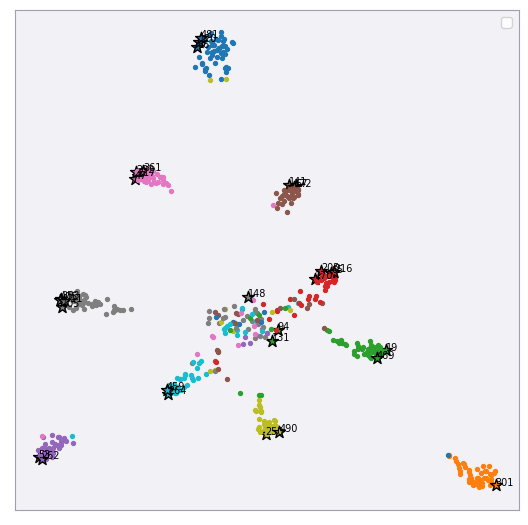

In [127]:
fig, axes = plt.subplots(1, 1, figsize=(6.5, 6.5))
# Plot result on the subplot
SAMple=simple_scatterplot(axes, X, train_labels[:1000], result,0)
print(SAMple)

In [13]:
import os
pictures_index=[479, 391, 452, 75, 329, 130, 305, 92, 491, 481, 420, 120, 140, 377, 396, 163, 187, 157, 1, 416, 359, 66, 362, 275, 60, 159, 183, 468, 271, 108, 240, 484, 176, 194, 225, 400, 38, 312, 333, 255, 257, 37, 58, 458, 72, 486, 171, 276, 317, 282, 438, 487, 151, 285, 344, 308, 78, 9, 24]
def save_pictures(pictures_index): 
    # 创建一个带有多个子图的图形
    picture = []
    for index in pictures_index:
        picture.append(train_images[index])
    plt.figure()
    for picture_cu, index in enumerate(pictures_index):
        img = train_images[index]
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(f'{index}', fontsize=24)
        plt.axis('off')
        output_directory = r'c:\Users\liuyi\Desktop'
        # 保存图像到本地
        image_file = os.path.join(output_directory, f'example_plot_{index}.png')
        plt.savefig(image_file, bbox_inches='tight', pad_inches=0)  # 指定文件名和格式

        # 显示图形（可选）
        plt.close()
def show_pictures(pictures_index): 
    # 创建一个带有多个子图的图形
    picture = []
    for index in pictures_index:
        picture.append(train_images[index])
    plt.figure()
    for picture_cu, index in enumerate(pictures_index):
        img = train_images[index]
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(f'{index}', fontsize=24)
        plt.axis('off')
        plt.show()
save_pictures(pictures_index)

<Figure size 640x480 with 0 Axes>

In [ ]:
vec=C[:,470]
print(vec[470])
for i in range(500):
    if vec[i]>0.00185:
        print(i,vec[i])

In [ ]:
for i in range(500):
    if C[i,i]>0.1:
        print(i,C[i,i])

### 根据select_num，计算其在result中的组合系数，挑出前20输出图片及coefficient

20


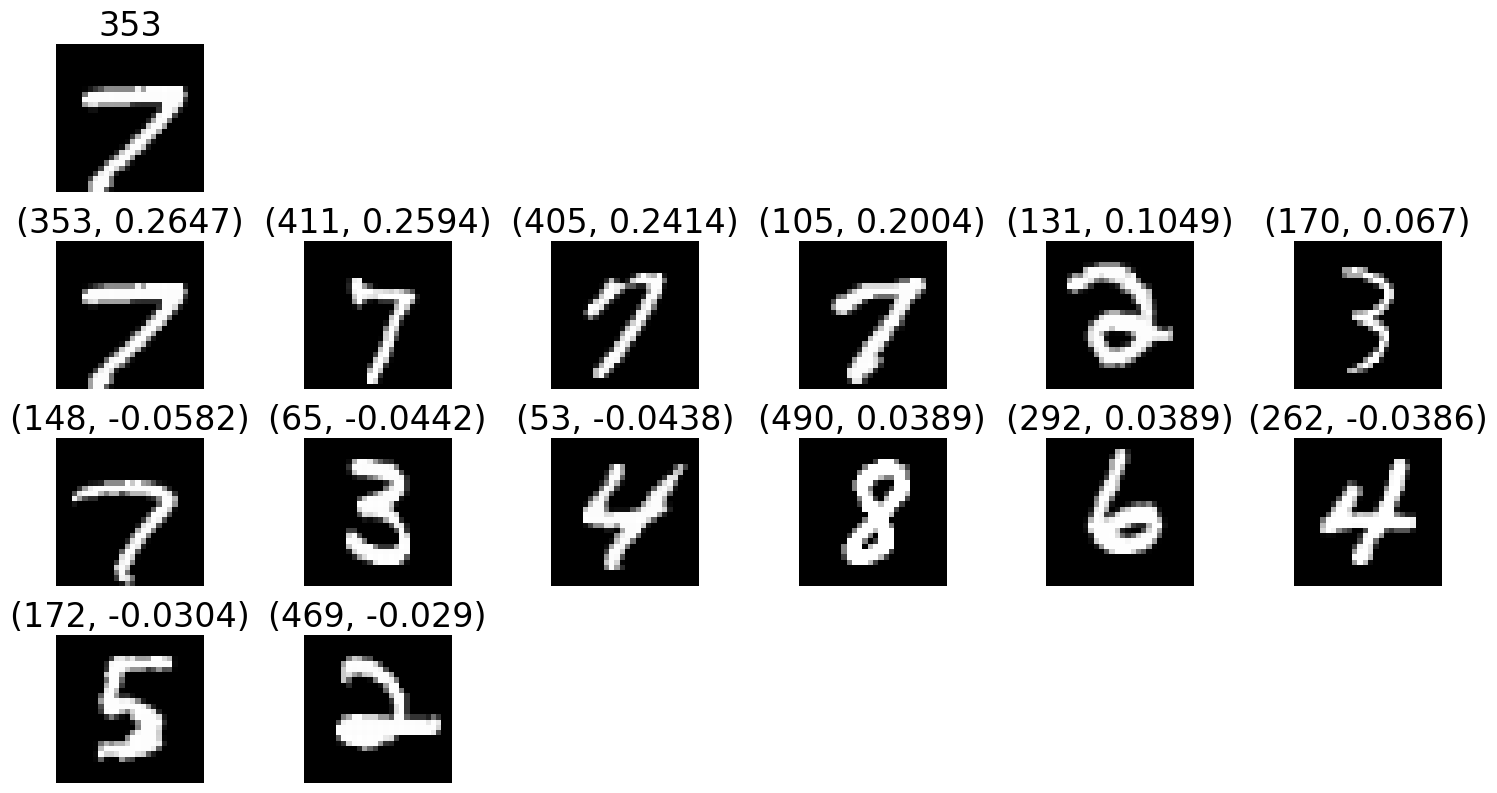

In [93]:
test_result=[x for x in result]
C1=calculate_C_bycp(X.T,test_result)[0]
select_num=353
cof_list=C1[test_result,select_num]
sorted_list=[]
for i in range(len(cof_list)):
    sorted_list.append((test_result[i],cof_list[i]))
sorted_list=sorted(sorted_list,key=lambda x:abs(x[1]),reverse=True)
sorted_list=sorted_list[:20]

#绘图
num_images = len(sorted_list)
print(len(sorted_list))
num_rows = (num_images + 5) // 6+1  # 使用整除来计算行数
# 创建一个新的图像，设置合适的大小
fig, axes = plt.subplots(num_rows, 6, figsize=(15, num_rows * 2))
index=select_num
img = train_images[index]
axes[0, 0].imshow(img,cmap='gray')  # 显示图像
axes[0, 0].axis('off')  # 隐藏坐标轴
axes[0, 0].set_title(f'{index}', fontsize=24)  # 设置标题
for picture_cu, index in enumerate(sorted_list):
    row = picture_cu // 6 +1 # 当前图像所在的行
    col = picture_cu % 6   # 当前图像所在的列
    img = train_images[index[0]]
    axes[row, col].imshow(img, cmap='gray')  # 显示图像
    axes[row, col].axis('off')  # 隐藏坐标轴
    axes[row, col].set_title(f'{index[0],round(index[1],4)}', fontsize=24)  # 设置标题
# 隐藏多余的子图
for col in range(1, 6):
    fig.delaxes(axes[0, col])
for i in range(num_images, num_rows * 6):
    row = i // 6
    col = i % 6
    fig.delaxes(axes[row, col])
# 调整子图之间的间距
plt.tight_layout()
plt.show()

### 看那些gain比较低的数字在包含该类的集合与不包含该类的集合下系数有何区别
对于每一个被测试的数字，我都会根据整理的不同形态的数字及编号图，将同类同形态的所有数字均加入result中，观察这两类set是如何组合这个测试数字的

In [68]:
num0=[50,150,161,376]
select_num= 46
print("原始result,测试的数字",select_num)
test_result=[x for x in result]
C1=calculate_C_bycp(X.T,test_result)[0]
mylist=[]

for i in range(500):
    if i in test_result and abs(C1[i,select_num])>0.02:
        mylist.append((i,C1[i,select_num]))
sorted_list = sorted(mylist, key=lambda x: abs(x[1]), reverse=True)
first_elements = []
second_elements = []
for tup in sorted_list[:10]:
    first_elements.append(round(tup[0],4))
    second_elements.append(round(tup[1],4))

print(first_elements)
print(second_elements)
for index in num0:
    print("result加入的数字",index)
    test_result=[x for x in result]
    test_result.append(index)
    C1=calculate_C_bycp(X.T,test_result)[0]
    mylist=[]
    for i in range(500):
        if i in test_result and abs(C1[i,select_num])>0.02:
            mylist.append((i,C1[i,select_num]))
    sorted_list = sorted(mylist, key=lambda x: abs(x[1]), reverse=True)
    first_elements = []
    second_elements = []
    for tup in sorted_list[:10]:
        first_elements.append(round(tup[0],4))
        second_elements.append(round(tup[1],4))

    print(first_elements)
    print(second_elements)

原始result,测试的数字 46
[94, 148, 131, 53, 262, 216, 65, 301, 66, 469]
[0.1468, 0.1453, 0.1174, 0.0774, 0.0652, 0.0511, 0.0427, 0.0409, 0.0384, 0.0292]
result加入的数字 50
[94, 148, 131, 53, 50, 262, 216, 65, 301, 66]
[0.1366, 0.1348, 0.1113, 0.0741, 0.0691, 0.0624, 0.0478, 0.04, 0.04, 0.0359]
result加入的数字 150
[94, 148, 131, 53, 262, 216, 65, 301, 66, 469]
[0.1468, 0.1452, 0.1176, 0.0774, 0.0652, 0.0512, 0.0427, 0.0407, 0.0384, 0.0291]
result加入的数字 161
[94, 148, 131, 53, 262, 216, 65, 66, 301, 469]
[0.1458, 0.1451, 0.1166, 0.0771, 0.0648, 0.0512, 0.0427, 0.0384, 0.0377, 0.029]
result加入的数字 376
[94, 148, 131, 53, 262, 216, 65, 301, 66, 469]
[0.1466, 0.1451, 0.1166, 0.0774, 0.0654, 0.0508, 0.0426, 0.0426, 0.0382, 0.0293]


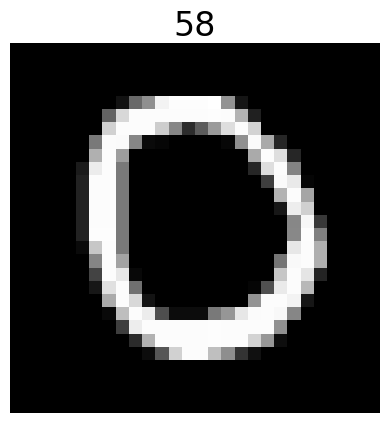

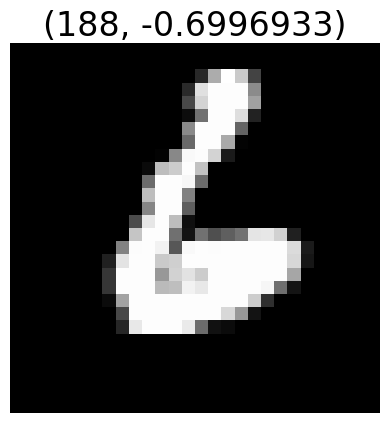

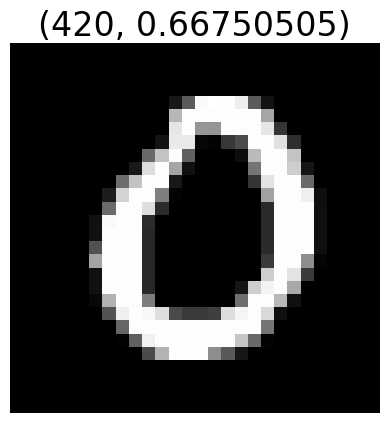

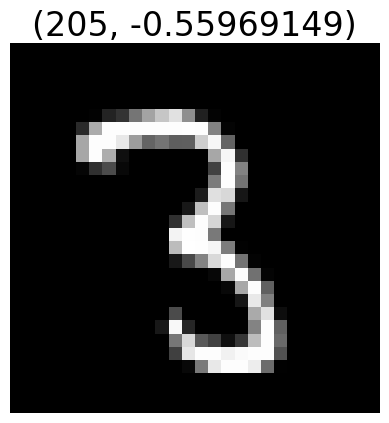

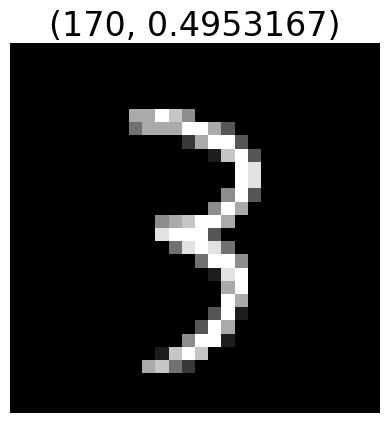

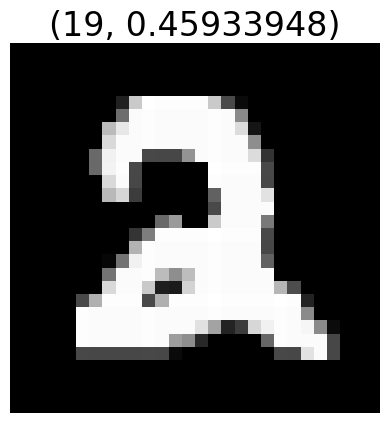

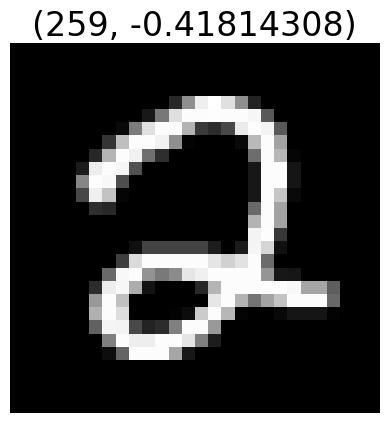

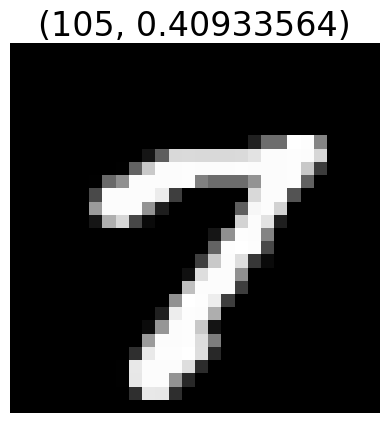

In [59]:
sorted_list=sorted_list[:20]
# 创建一个带有多个子图的图形
picture = []
for index in sorted_list:
    picture.append(train_images[index[0]])
plt.figure()
index=58
img = train_images[index]
plt.imshow(img, cmap='gray')
plt.title(f'{index}', fontsize=24)
plt.axis('off')
for picture_cu, index in enumerate(sorted_list):
    img = train_images[index[0]]
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f'{index[0],round(index[1],8)}', fontsize=24)
    plt.axis('off')
    plt.show()

### 比较p=1和p=inf的两个C矩阵性质差异

In [161]:
X=np.load('check.npy')
print(X.shape)
dist=euclidean_distances(X,X)
SS=SubsetSelection(X,100,dist)
start=time.time()
(C,value)=SS.ADMM_SparseModeling_bycvxpy(2e5,1)
np.save('C.npy',C)
print(time.time()-start)
result=FindMinByC(C,30/500,np.inf)

(500, 10)
(10, 500)
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Sep 08 03:59:25 PM: Your problem has 250000 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 08 03:59:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 08 03:59:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 08 03:59:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 08 03:59:25 PM: Compiling problem (target solver=ECOS).
(CVXPY) Sep 08 03:59:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [160]:
print(result,C)
result_p_inf=result
C_p_inf=C

[205 170 469 216  19 251 352 381  47 188 249  57 490 481 105  65  20 349
 397 160 292 148 217 304 473 405 259 189 290 458] [[ 9.99999846e-01  3.84556096e-11  2.96523381e-10 ... -1.85945730e-11
   1.18177872e-10  1.14232019e-10]
 [ 2.10752412e-10  9.99999872e-01  1.59990280e-10 ...  1.31990233e-10
  -3.42295908e-11  4.04742053e-11]
 [ 2.77188119e-10  9.31546117e-11  9.99999874e-01 ...  3.35231460e-10
   4.55851750e-10  1.18559294e-10]
 ...
 [ 3.44311044e-11  4.61484634e-11  3.72379947e-10 ...  9.99999862e-01
   3.11270737e-11  1.43956416e-10]
 [ 1.18402990e-10 -3.98035825e-11  7.15103676e-10 ... -4.15052844e-11
   9.99999908e-01 -9.35458500e-11]
 [ 2.33399136e-10  4.63122395e-11  2.15318446e-10 ...  9.53096503e-11
   3.22282534e-11  9.99999860e-01]]


In [162]:
print(result,C)
result_p_1=result
C_p_1=C

[ 19 216 205  47 490 264 292  53 353  65 141 481 301 469 262 148  66 250
 405  67 120 361 459 105  94 170 411 131 217 172] [[ 1.99667180e-03  8.86730459e-10  7.80162137e-09 ...  1.98286938e-09
   2.35782549e-09  1.39886328e-09]
 [ 2.29480294e-04  9.99996257e-01  1.20268538e-08 ...  1.25059372e-08
   6.79025960e-11  1.57905896e-09]
 [ 1.74397768e-04  1.43193459e-09  9.99991456e-01 ...  6.17442427e-09
   5.88677713e-09  3.76790824e-09]
 ...
 [ 1.42153132e-04  1.47992776e-09  1.44305041e-08 ...  9.99993417e-01
   2.86391626e-09  6.70578746e-09]
 [ 9.18442103e-05  4.36463594e-10  1.47756626e-08 ... -1.88508076e-10
   9.99994888e-01 -3.11536033e-10]
 [ 7.25613274e-04  3.12814002e-09  4.33226576e-08 ...  3.86456549e-09
   6.72892695e-09  9.99989054e-01]]


In [163]:
print(np.linalg.norm(X.T-X.T.dot(C_p_inf),ord='fro'),np.linalg.norm(X.T-X.T.dot(C_p_1),ord='fro'))
print(100*np.linalg.norm(C_p_inf,ord=np.inf),100*np.linalg.norm(C_p_1,ord=1))
print(100*np.linalg.norm(C_p_inf,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_inf),ord='fro'),100*np.linalg.norm(C_p_1,ord=1)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_1),ord='fro'))





print(100*np.linalg.norm(C_p_inf,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_inf),ord='fro'),100*np.linalg.norm(C_p_1,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_1),ord='fro'))
print(100*np.linalg.norm(C_p_inf,ord=1)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_inf),ord='fro'),100*np.linalg.norm(C_p_1,ord=1)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_1),ord='fro'))

4.155372582763727e-06 0.03481747384285741
100.000012315263 100.00006934290391
100.0000143929493 100.01747807982534
100.0000143929493 665.6056297936649
100.00000878987576 100.01747807982534


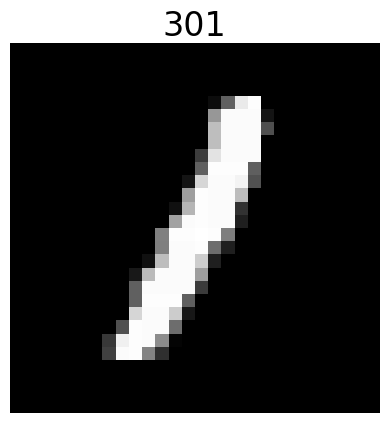

1.314775013953764 0.9999998714597584
0.9999989247921349 0.999999871459758


In [168]:
select_num=301
img = train_images[select_num]
plt.figure()
plt.imshow(img, cmap='gray')
plt.title(f'{select_num}', fontsize=24)
plt.axis('off')
plt.show()
print(np.linalg.norm(C_p_1[select_num,:]),np.linalg.norm(C_p_inf[select_num,:]))
print(C_p_1[select_num,select_num],C_p_inf[select_num,select_num])

In [171]:
import copy
C_p_inf_revised=copy.deepcopy(C_p_inf)
bad_num=20
good_num=301
C_p_inf_revised[bad_num,bad_num]=0.999999871459758
C_p_inf_revised[good_num,good_num]=0.9999999349502392
print(100*np.linalg.norm(C_p_inf,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_inf),ord='fro'),100*np.linalg.norm(C_p_inf_revised,ord=np.inf)+0.5*np.linalg.norm(X.T-np.dot(X.T,C_p_inf_revised),ord='fro'))
print(100*np.linalg.norm(C_p_inf,ord=np.inf),100*np.linalg.norm(C_p_inf_revised,ord=np.inf))
print(np.linalg.norm(X.T-np.dot(X.T,C_p_inf),ord='fro'),np.linalg.norm(X.T-np.dot(X.T,C_p_inf_revised),ord='fro'))

100.0000143929493 100.0000169268146
100.000012315263 100.00001476341384
4.155372582763727e-06 4.326801489052341e-06


In [18]:
select_combination=[108,176,312,359,72,485,5,21,129,393,381,119,110,16,287,426,122,261,360,169]

X1=X[select_combination]
print(X1.shape)
dist=euclidean_distances(X1,X1)
SS=SubsetSelection(X1,60,dist)
start=time.time()
(C,value)=SS.ADMM_SparseModeling_bycvxpy(2e5,np.inf)
result=FindMinByCnorm(C,0.3,np.inf)

(20, 10)
(10, 20)


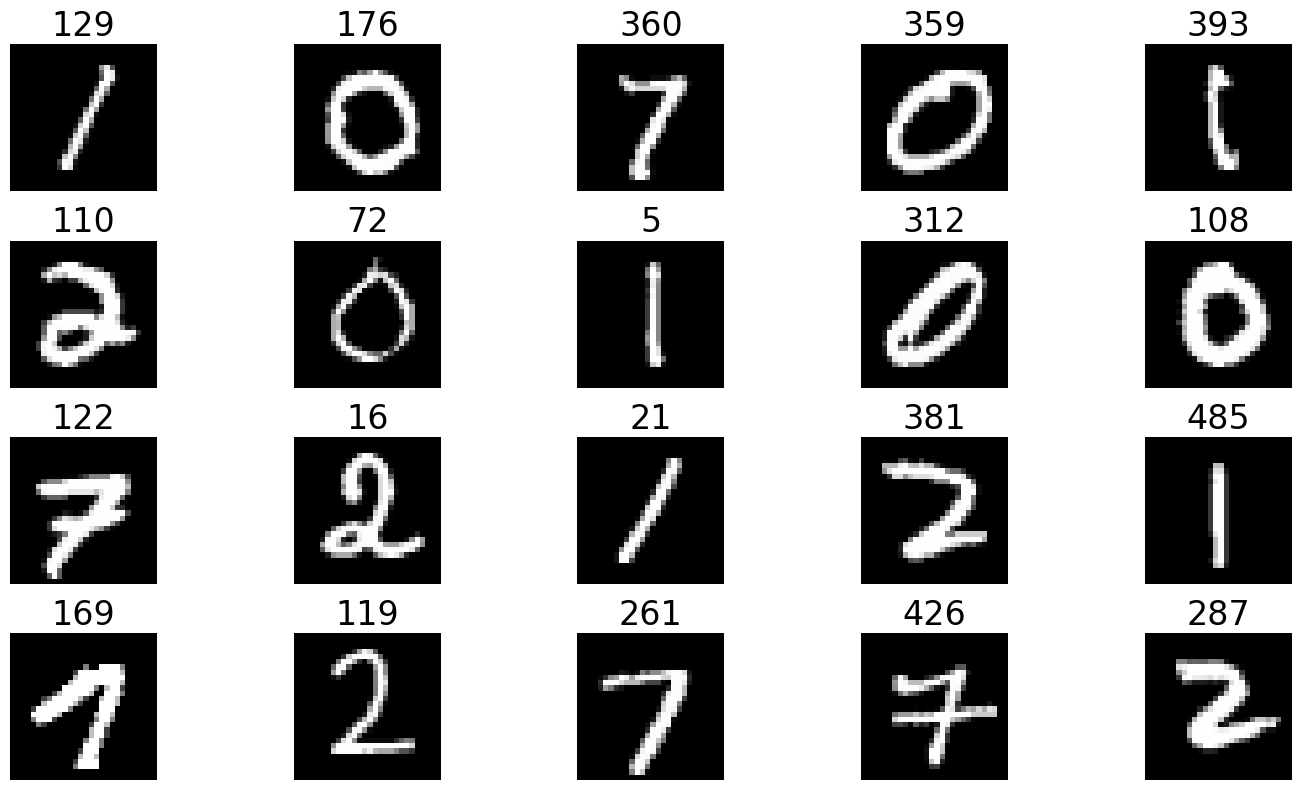

In [15]:
sorted_comb=[129, 176, 360, 359, 393, 110, 72, 5, 312, 108, 122, 16, 21, 381, 485, 169, 119, 261, 426, 287]
num_images = 5
num_rows = 4
# 创建一个新的图像，设置合适的大小
fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 2))
for picture_cu, index in enumerate(sorted_comb):
    row = picture_cu // 5  # 当前图像所在的行
    col = picture_cu % 5   # 当前图像所在的列
    img = train_images[index]
    axes[row, col].imshow(img, cmap='gray')  # 显示图像
    axes[row, col].axis('off')  # 隐藏坐标轴
    axes[row, col].set_title(f'{index}', fontsize=24)  # 设置标题
# 调整子图之间的间距
plt.tight_layout()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] (20, 20)
[108, 176, 312, 359, 72, 485, 5, 21, 129, 393, 381, 119, 110, 16, 287, 426, 122, 261, 360, 169]


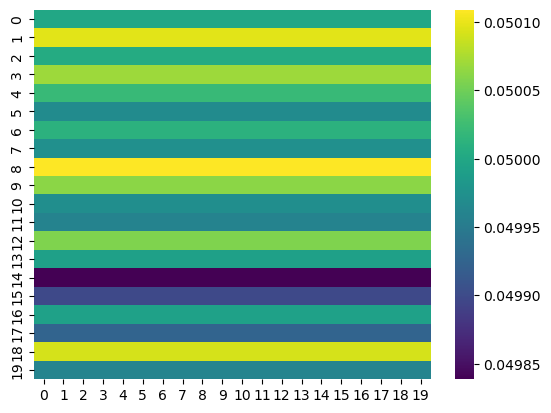

In [19]:
print(result,C.shape)
sortlist=[]
for i in result:
    sortlist.append(select_combination[i])
print(sortlist)
import seaborn as sns
# 创建热图
sns.heatmap(C, cmap='viridis')  # 使用 'viridis' 颜色映射，你可以根据需要更改
plt.show()
np.save('C_inf.npy',C)

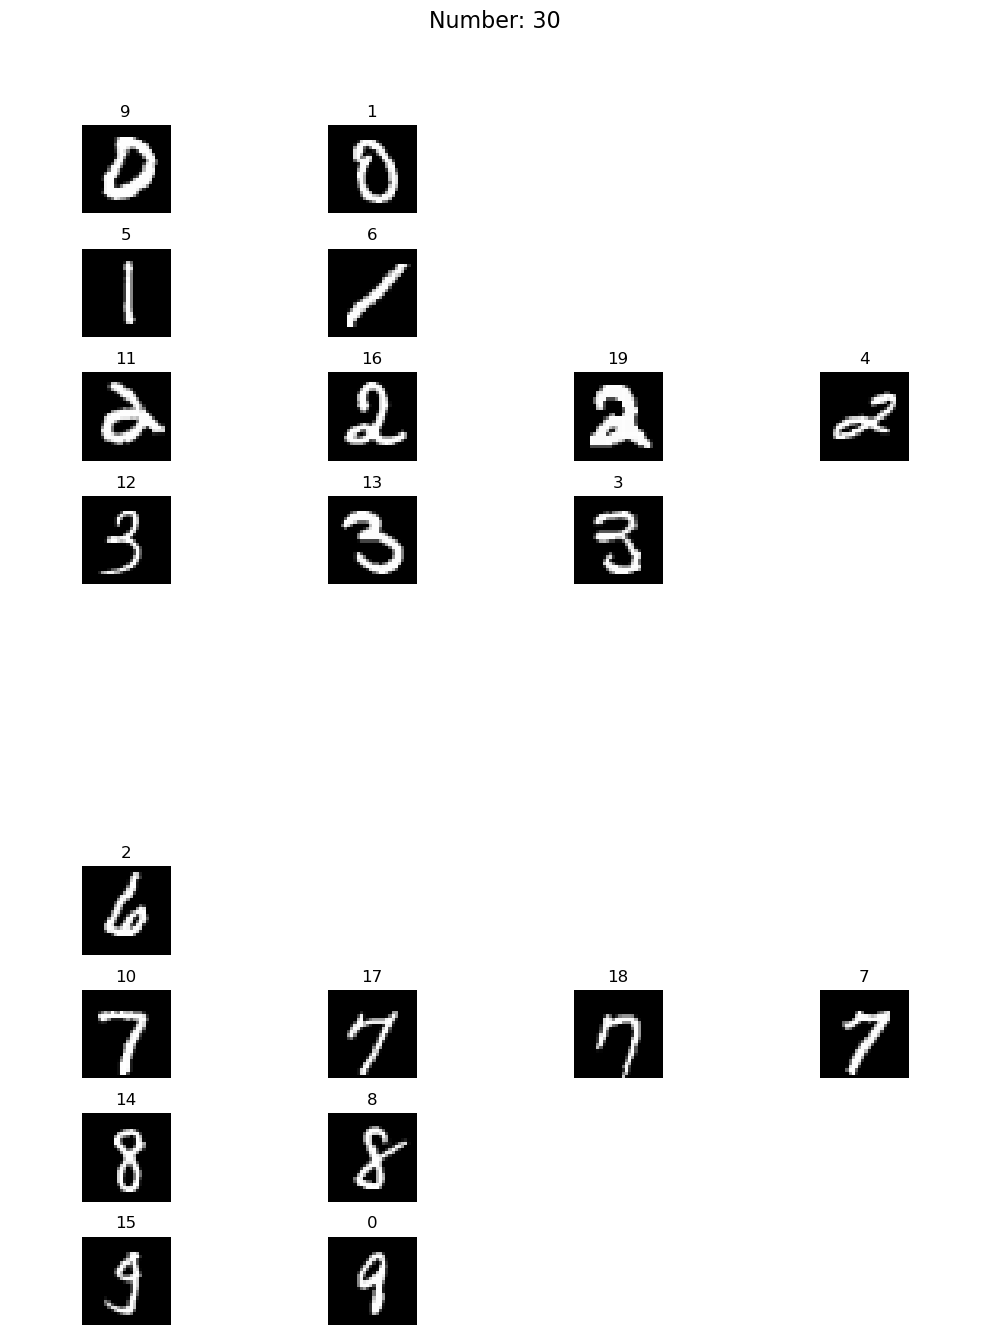

图像已保存至PDF文件： MNIST_Pictures_finetune.pdf


In [182]:

import random
pdf_filename = "MNIST_Pictures_finetune.pdf"
pdf_pages = PdfPages(pdf_filename)
# 设置每个图像的大小
image_size = (28, 28)
test_num=30
# 计算每行展示的列数
num_cols = 4
percent_list=[0.3]
for percent in percent_list:
    result = FindMinByC(C, 20/20, np.inf)
    labels = [0]*10
    picture = [[] for _ in range(10)]
    picture_index = [[] for _ in range(10)]
    for index in result:
        labels[train_labels[index]] += 1
        picture[train_labels[index]].append(train_images[index])
        picture_index[train_labels[index]].append(index)
    # 计算每个图像在每行展示的列数
    max_cols = max(len(picture_cu) for picture_cu in picture)
    num_cols = max(num_cols, max_cols)  # 限制最大列数为10
    num_cols=min(num_cols,20)
    # 计算每个图像的缩放比例
    scale_factor = image_size[0] / (num_cols * image_size[1])

    # 创建一个带有多个子图的图形
    fig, axes = plt.subplots(10, num_cols, figsize=(10, 14))
    # 在每个子图中使用imshow显示不同的图像
    for i, picture_cu in enumerate(picture):
        if len(picture_cu) > 20:
            picture_cu = random.sample(picture_cu, 20)
        for j in range(num_cols):
            if j < len(picture_cu):
                img = picture_cu[j]
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].title.set_text(f'{picture_index[i][j]}')
            axes[i, j].axis('off')
    # 设置图形标题和子图布局
    fig.suptitle(f'Number: {test_num}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 保存图形到PDF文件
    pdf_pages.savefig(fig)

# 关闭PDF文件
pdf_pages.close()
plt.show()
print("图像已保存至PDF文件：", pdf_filename)

In [200]:
C=np.load('C_inf.npy')
print(C)

[[9.99996296e-01 9.27996929e-07 1.24898892e-06 4.07229215e-07
  3.43206658e-07 4.16962354e-08 4.76654130e-08 2.99315928e-08
  3.05559318e-08 6.34793485e-08 3.70572863e-08 5.11528117e-08
  6.49225139e-08 5.14593099e-08 4.34574496e-08 4.75755598e-08
  6.42297458e-08 5.12614012e-08 7.29335234e-08 8.03383092e-08]
 [9.67230670e-07 9.99996879e-01 6.51642755e-07 3.14655213e-07
  4.20468088e-07 4.00209395e-08 4.70000159e-08 2.90089341e-08
  3.04093935e-08 6.11748775e-08 3.86450025e-08 4.86363110e-08
  6.67697534e-08 5.14775927e-08 4.55646343e-08 4.56047464e-08
  5.72360979e-08 5.24562981e-08 7.56746677e-08 7.97563075e-08]
 [1.31621937e-06 7.05638192e-07 9.99995880e-01 5.50986630e-07
  7.11293525e-07 4.37781794e-08 4.99272597e-08 3.10518475e-08
  3.20974193e-08 6.88388742e-08 4.14247644e-08 5.46697882e-08
  7.60525721e-08 5.34253254e-08 4.72857262e-08 5.14804935e-08
  6.85916524e-08 5.40996181e-08 7.75895484e-08 8.50984849e-08]
 [4.01973359e-07 2.83096376e-07 6.00107709e-07 9.99997828e-01
  2.0

In [202]:
print(100*np.linalg.norm(C,ord=np.inf)+0.5*np.linalg.norm(X1.T-np.dot(X1.T,C),ord='fro'))
print(100*np.linalg.norm(C,ord=np.inf),0.5*np.linalg.norm(X1.T-np.dot(X1.T,C),ord='fro'))

100.00002164652226
100.00000136734837 2.0279173875142684e-05
